## Import dependencies

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import random_split
from collections import defaultdict
import random
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler
import torch.nn.functional as F
import torch.nn.init as init
import itertools
import copy
from tqdm import tqdm
import statistics
import pandas as pd
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
import io
import sys


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU")

GPU is available. Using Tesla T4


# Load data and split in the multi agent system


In [4]:
#Set up main parameters
num_agents = 10
batch_size = 32
test_batch_size = 64

In [5]:
# def load_cifar10():
#     transform = transforms.Compose(
#         [transforms.ToTensor(),
#          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#     train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                                  download=True, transform=transform)
#     test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                                 download=True, transform=transform)
#     return train_dataset, test_dataset


def load_fashion():
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))])
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                 download=True, transform=transform)
    test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                download=True, transform=transform)
    return train_dataset, test_dataset


def load_svhn():
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_dataset = torchvision.datasets.SVHN(root='./data', split='train',
                                                 download=True, transform=transform)
    test_dataset = torchvision.datasets.SVHN(root='./data', split='test',
                                                download=True, transform=transform)
    return train_dataset, test_dataset


# def load_mnist():
#     transform = transforms.Compose(
#         [transforms.ToTensor(),
#          transforms.Normalize((0.5), (0.5))])

#     train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
#                                                  download=True, transform=transform)
#     test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
#                                                 download=True, transform=transform)
#     return train_dataset, test_dataset


# def split_dataset_heterogeneously(dataset, num_agents, alpha=.8):
#     np.random.seed(42)
#     num_samples = len(dataset)
#     indices = np.random.permutation(num_samples)
#     # Generate Dirichlet distribution for each agent
#     proportions = np.random.dirichlet(np.repeat(alpha, num_agents), size=1)[0]
#     # Calculate the number of samples for each agent
#     agent_sizes = (proportions * num_samples).astype(int)
#     # Adjust to ensure all samples are allocated
#     agent_sizes[-1] = num_samples - np.sum(agent_sizes[:-1])

#     agent_splits = []
#     start_idx = 0
#     for size in agent_sizes:
#         end_idx = start_idx + size
#         agent_indices = indices[start_idx:end_idx]
#         agent_subset = Subset(dataset, agent_indices.tolist())
#         agent_splits.append(agent_subset)
#         start_idx = end_idx

#     return agent_splits, proportions

# def create_dataloaders(train_splits, val_splits, test_set, batch_size=32, test_batch_size=32):
#     train_loaders = []
#     val_loaders = []
#     test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

#     for train_data, val_data in zip(train_splits, val_splits):
#         train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
#         val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
#         train_loaders.append(train_loader)
#         val_loaders.append(val_loader)

#     return train_loaders, val_loaders, test_loader

# def imshow(img):
#     img = img / 2 + 0.5  # unnormalize if necessary
#     npimg = img.numpy()

#     # Check if the image has 1 channel (grayscale)
#     if npimg.shape[0] == 1:
#         plt.imshow(npimg[0], cmap='gray')
#     else:
#         plt.imshow(np.transpose(npimg, (1, 2, 0)))

#     plt.show()


# def import_dataLoaders(data, num_agents=10, batch_size=32, test_batch_size=64, plot = True):
#   if data == 'MNIST':
#     train_dataset, test_dataset = load_mnist()
#   elif data=='FASHION':
#     train_dataset, test_dataset = load_fashion()
#   elif data=='SVHN':
#     train_dataset, test_dataset = load_svhn()
#   # Split train dataset into train and validation sets
#   train_size = int(0.8 * len(train_dataset))
#   val_size = len(train_dataset) - train_size
#   train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
#   # Split train and validation sets heterogeneously among agents
#   train_splits, train_proportions = split_dataset_heterogeneously(train_dataset, num_agents)
#   val_splits, val_proportions = split_dataset_heterogeneously(val_dataset, num_agents)
#   # Create dataloaders for each agent
#   train_loaders, val_loaders, test_loader = create_dataloaders(train_splits, val_splits, test_dataset, batch_size, test_batch_size)
#   # Print and plot the first batch of the first agent
#   dataiter = iter(train_loaders[0])
#   images, labels = dataiter.__next__()
#   print("First batch of the first agent:")
#   print(f"  Images shape: {images.shape}")
#   print(f"  Labels: {labels}")
#   # Plot the images
#   if plot ==True:
#     imshow(torchvision.utils.make_grid(images))
#   # Verify the size of the test loader
#   print(f"Test loader batch size: {test_loader.batch_size}")
#   #display distribution of data volumes in the system
#   if plot==True:
#     agents = [f'Agent {i}' for i in range(num_agents)]
#     plt.bar(agents, train_proportions)
#     plt.xlabel('Agents')
#     plt.ylabel('Proportion of data')
#     plt.title('Data Allocation by Dirichlet Distribution')
#     plt.show()
#   return train_loaders, val_loaders, test_loader

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.utils.data import DataLoader, Subset, random_split
import torchvision
import torchvision.transforms as transforms

# Split the dataset heterogeneously by label
def split_dataset_heterogeneously_by_label(dataset, num_agents, custom_volume_proportions=None, alpha_label=2.5):
    np.random.seed(42)
    num_samples = len(dataset)
    volume_proportions = (
        np.array(custom_volume_proportions)
        if custom_volume_proportions
        else np.random.dirichlet(np.repeat(1.0, num_agents))
    )
    agent_sizes = (volume_proportions * num_samples).astype(int)
    agent_sizes[-1] = num_samples - np.sum(agent_sizes[:-1])  # Adjust the last agent's size

    labels = [label for _, label in dataset]
    all_indices = np.arange(len(dataset))
    np.random.shuffle(all_indices)

    agent_indices = []
    start_idx = 0
    for size in agent_sizes:
        agent_indices.append(all_indices[start_idx:start_idx + size].tolist())
        start_idx += size

    agent_splits = [[] for _ in range(num_agents)]
    label_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        label_indices[label].append(idx)

    for agent in range(num_agents):
        agent_label_indices = agent_indices[agent]
        label_proportions = np.random.dirichlet(np.repeat(alpha_label, len(label_indices)))
        label_proportions = (label_proportions * len(agent_label_indices)).astype(int)
        label_proportions[-1] = len(agent_label_indices) - np.sum(label_proportions[:-1])

        for (label, count) in zip(label_indices.keys(), label_proportions):
            current_indices = [idx for idx in agent_label_indices if labels[idx] == label]
            np.random.shuffle(current_indices)
            agent_splits[agent].extend(current_indices[:count])

    return [Subset(dataset, indices) for indices in agent_splits]

# Split validation dataset based on different volumes and label distributions in training set
def split_validation_heterogeneously_by_train_labels(val_dataset, train_label_distributions, custom_val_volume_proportions, alpha_label=0.8):
    np.random.seed(42)
    val_size = len(val_dataset)

    # Use custom validation volume proportions for different agent volumes
    agent_val_sizes = (np.array(custom_val_volume_proportions) * val_size).astype(int)
    agent_val_sizes[-1] = val_size - np.sum(agent_val_sizes[:-1])  # Adjust to ensure full allocation

    val_labels = [label for _, label in val_dataset]
    all_val_indices = np.arange(len(val_dataset))
    np.random.shuffle(all_val_indices)

    agent_splits = [[] for _ in range(len(train_label_distributions))]
    label_indices = defaultdict(list)
    for idx, label in enumerate(val_labels):
        label_indices[label].append(idx)

    for agent in range(len(train_label_distributions)):
        agent_label_sizes = train_label_distributions[agent]
        total_agent_samples = agent_val_sizes[agent]
        label_proportions = np.random.dirichlet(np.repeat(alpha_label, len(agent_label_sizes)))
        label_proportions = (label_proportions * total_agent_samples).astype(int)
        label_proportions[-1] = total_agent_samples - np.sum(label_proportions[:-1])

        for (label, count) in zip(agent_label_sizes.keys(), label_proportions):
            current_indices = [idx for idx in all_val_indices if val_labels[idx] == label]
            np.random.shuffle(current_indices)
            agent_splits[agent].extend(current_indices[:count])

    return [Subset(val_dataset, indices) for indices in agent_splits]

# Create DataLoaders
def create_dataloaders(train_splits, val_splits, test_set, batch_size=32, test_batch_size=32):
    train_loaders = [DataLoader(agent, batch_size=batch_size, shuffle=True) for agent in train_splits]
    val_loaders = [DataLoader(agent, batch_size=batch_size, shuffle=False) for agent in val_splits]
    test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)
    return train_loaders, val_loaders, test_loader

# Load MNIST Dataset
def load_mnist():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    return train_dataset, test_dataset

# Plot volume distribution for each agent
def plot_volume_distribution(train_splits, val_splits, num_agents):
    train_volumes = [len(agent) for agent in train_splits]
    val_volumes = [len(agent) for agent in val_splits]

    agents = [f'Agent {i+1}' for i in range(num_agents)]
    x = np.arange(num_agents)

    plt.figure(figsize=(12, 6))
    plt.bar(x - 0.2, train_volumes, 0.4, label='Training Set Volume')
    plt.bar(x + 0.2, val_volumes, 0.4, label='Validation Set Volume')

    plt.xlabel('Agents')
    plt.ylabel('Number of Samples')
    plt.xticks(x, agents)
    plt.title('Volume Distribution Across Agents (Train vs. Validation)')
    plt.legend()
    plt.grid(axis='y', linestyle='--')
    plt.show()

# Plot label distribution for each agent
def plot_label_distribution(agents_labels, num_agents, title):
    labels = list(agents_labels[0].keys())
    label_counts = np.array([[agents_labels[agent][label] for label in labels] for agent in range(num_agents)])
    agents = [f'Agent {i+1}' for i in range(num_agents)]
    bottom = np.zeros(num_agents)

    plt.figure(figsize=(12, 6))
    for i, label in enumerate(labels):
        plt.bar(agents, label_counts[:, i], bottom=bottom, label=f'Label {label}')
        bottom += label_counts[:, i]

    plt.xlabel('Agents')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(title='Labels')
    plt.grid(axis='y', linestyle='--')
    plt.show()

def import_dataLoaders(data, num_agents=10, batch_size=32, test_batch_size=64, plot=True, label_het_val=2.5, label_het_train=1.5):
    if data == 'MNIST':
        train_dataset, test_dataset = load_mnist()
    elif data=='FASHION':
        train_dataset, test_dataset = load_fashion()
    elif data=='SVHN':
        train_dataset, test_dataset = load_svhn()
    else:
        raise ValueError("Unsupported dataset. Use 'MNIST'.")

    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    custom_train_volumes = [0.09, 0.09, 0.02, 0.05, 0.01, 0.34, 0.20, 0.07, 0.10,0.03]
    custom_val_volumes=[0.108, 0.108, 0.024, 0.060, 0.012, 0.408, 0.240, 0.084, 0.120, 0.036]


    train_splits = split_dataset_heterogeneously_by_label(train_dataset, num_agents, custom_volume_proportions=custom_train_volumes, alpha_label=label_het_train)

    # Capture training label distributions for each agent
    train_label_distributions = []
    for agent_data in train_splits:
        label_counts = {i: 0 for i in range(10)}
        for _, label in agent_data:
            label_counts[label] += 1
        train_label_distributions.append(label_counts)

    # Split validation set based on new custom volumes and training label distributions
    val_splits = split_validation_heterogeneously_by_train_labels(val_dataset, train_label_distributions, custom_val_volume_proportions=custom_val_volumes, alpha_label=label_het_val)

    train_loaders, val_loaders, test_loader = create_dataloaders(train_splits, val_splits, test_dataset, batch_size, test_batch_size)

    if plot:
        # Plot volume distributions
        plot_volume_distribution(train_splits, val_splits, num_agents)

        # Plot label distributions
        plot_label_distribution(train_label_distributions, num_agents, title="Training Set Label Distribution Across Agents")
        val_label_distributions = []
        for agent_data in val_splits:
            label_counts = {i: 0 for i in range(10)}
            for _, label in agent_data:
                label_counts[label] += 1
            val_label_distributions.append(label_counts)
        plot_label_distribution(val_label_distributions, num_agents, title="Validation Set Label Distribution Across Agents")

    # Ensure the function returns the correct objects
    return train_loaders, val_loaders, test_loader

# Create Graph Topology

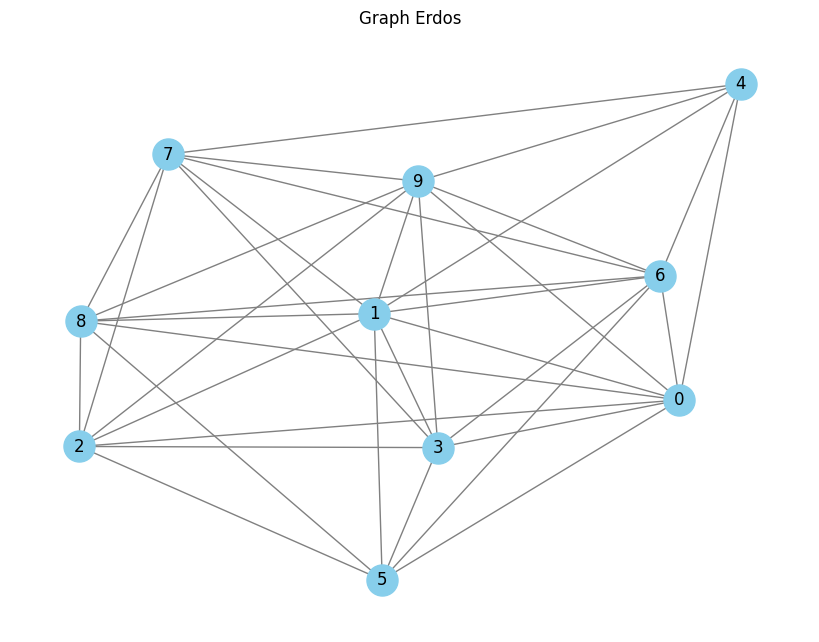

In [41]:
# Set a specific seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)  # Set seed for CPU
    torch.cuda.manual_seed(seed)  # Set seed for current GPU
    torch.cuda.manual_seed_all(seed)  # Set seed for all GPUs (if using multi-GPU)
    torch.backends.cudnn.deterministic = True  # Make cuDNN deterministic (reproducibility)
    torch.backends.cudnn.benchmark = False  # Avoid non-deterministic algorithms


def genera_grafo_connesso(tipo_grafo, num_nodi, prob=None, m=None, seed=None):
    while True:
        if tipo_grafo == 'erdos':
            if prob is None:
                raise ValueError("Per un grafo di Erdos-Renyi, specificare la probabilità 'prob'")
            G = nx.erdos_renyi_graph(num_nodi, prob, seed=seed)
        elif tipo_grafo == 'scale_free':
            if m is None:
                raise ValueError("Per un grafo scale-free, specificare il numero di archi 'm'")
            G = nx.barabasi_albert_graph(num_nodi, m, seed=seed)
        else:
            raise ValueError("Tipo di grafo non supportato. Scegliere tra 'erdos_renyi' o 'scale_free'")

        # Controlla se il grafo è connesso
        if nx.is_connected(G):
            break

    adj_matrix = nx.adjacency_matrix(G).todense()
    laplacian_matrix = nx.laplacian_matrix(G).todense()
    # Save the node positions with a specific layout (spring layout for example)
    pos = nx.spring_layout(G, seed=seed)
    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
    plt.title(f"Graph {tipo_grafo.replace('_', ' ').title()}")
    plt.show()
    return adj_matrix, laplacian_matrix, G

set_seed(1)
type_g = 'erdos'
p = 0.75
Adj_matrix, L, G = genera_grafo_connesso(type_g, num_agents, prob=p, seed=42)
# print("Matrice di adiacenza:\n", A)
# print("Laplaciano:\n", L

# Define learning function at the edge of the network

In [8]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # GPU
    random.seed(seed)

# class Net(nn.Module):
#     def __init__(self, input_channels=images.shape[1], num_classes=10):
#         super(Net, self).__init__()
#         #set_random_seed(seed)

#         self.conv1 = nn.Conv2d(images.shape[1], 8, kernel_size=5)
#         self.fc1 = nn.Linear(8 * 24 * 24, 32)  # Adjust input size for fully connected layer
#         self.fc2 = nn.Linear(32, num_classes)

#         # Initialize weights
#         self._initialize_weights()

#     def forward(self, x):
#         x = F.gelu(self.conv1(x))  # Using GELU activation function
#         x = x.view(-1, 8 * 24 * 24)
#         x = F.gelu(self.fc1(x))
#         x = self.fc2(x)            # Output layer
#         return x

#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#                 init.xavier_normal_(m.weight)
#                 if m.bias is not None:
#                     init.constant_(m.bias, 0)


class Net(nn.Module):
    def __init__(self, dataset='CIFAR', num_classes=10, seed=42):
        super(Net, self).__init__()
        set_random_seed(seed)
        if dataset == 'MNIST' or dataset == 'FASHION':
            self.input_channels = 1  # 1 channel (grayscale)
            self.input_size = 28  # Images are 28x28
        else:  # CIFAR-10
            self.input_channels = 3  # CIFAR-10 has 3 channels (RGB)
            self.input_size = 32  # CIFAR-10 images are 32x32
        self.conv1 = nn.Conv2d(self.input_channels, 8, kernel_size=5)

        # Compute output size after convolution
        # New size = input_size - kernel_size + 1
        self.conv_output_size = self.input_size - 5 + 1
        # Fully connected layers
        self.fc1 = nn.Linear(8 * self.conv_output_size * self.conv_output_size, 32)  # Flatten conv output
        self.fc2 = nn.Linear(32, num_classes)  # Output layer
        self._initialize_weights()

    def forward(self, x):
        # Apply the first convolutional layer and GELU activation
        x = F.gelu(self.conv1(x))
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 8 * self.conv_output_size * self.conv_output_size)
        # Fully connected layers with GELU activation
        x = F.gelu(self.fc1(x))
        # Output layer
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        # Xavier initialization for Conv2d and Linear layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)


# Define Successive Convex Approximation routine:
$$ min_{\omega} U(\omega) = F(\omega)+G(\omega) \\
U_i(x) = f_i(\omega_i,x_i) + \sum_{j=1}^I f_j(\omega_i,x_j) + G(\omega_i) ; i=\{1,..,N\}$$
Where $G(\omega)$ is a convex regularized defined as $||\omega_i||^2$.
- The surrogate function for *full linearization* (FL) of the initial possibly non convex cost function is defined as a proximal gradient procedure: $$\tilde{f_i}(x_i|x_i[n])= f_i(x_i[n]) + \nabla f_i(x_i[n])(x_i - x_i[n]) + \frac{\tau}{2}||x_i - x_i[n] ||$$
That solved in closed form produces:
$$\nabla_{x} \tilde{F}(x^k|x_i[n])=0 \\
\nabla_{x}F(x_i[n]) + \tau(x^k-x_i[n])=0 \\
x^{k+1}= x^k - \frac{1}{\tau} \nabla F(x_i[n])$$

- Best Response map aims to approximate for each agent $i^{th}$:
$$ \hat{\omega_i}(\omega_i[n]) = argmin_{x\omega_i[n] \in K} \tilde{f_i}(\omega_i|\omega_i[n]) + (\omega_i-\omega_i[n]) \sum_{j \neq i} ^N \nabla_x f_j(\omega_i[n]) $$

- Convex smooth combination:
$$ \omega_i[n+1] = \omega_i [n] + \gamma^k(\hat{\omega_i}(\omega_i[n])-\omega_i [n]) $$

The main idea is to develop a gradient tracking method to implement a fully distributed framework where $\sum_{j \neq i} ^N \nabla_{\omega_i} f_j(\omega_i[n])$, that is not distributed since anget $i$ need the knowledge of all $j^{}th$ agents gadients; \
Furthermore, the use of dynamic consensus to update the
 objective functions of users' subproblems is a novel idea
 (introduced for the first time in "NEXT-Di Lorenzo & Scutari"), which makes the proposed scheme convergent even in the case of nonconvex
 $F$'s (as in the case of multi-agent systems).


# Bio-Inspired in-Network succEssive conveX approximaTion (NEXT)

  **Initialization:**  
  $ \omega_i[0] \in \mathcal{K}, y_i[0] = \nabla f_i[0], \tilde{\pi}_i[0] = Iy_i[0] - \nabla f_i[0], \forall i = \{1, \dots, N\} $  
  $ W_{ij} = I  -\epsilon L   \ \ \ with  \epsilon < \frac{2}{\lambda_{max} L}$

  ---

  (S.1)  If $  \|\hat{\omega}(\omega^k) - \omega^k\| < tolerance $ : STOP;

  ---

  (S.2) *Local SCA optimization*:  
  Each agent $i^{th}: $

  (a) Computes locally $ \tilde{\omega}_i[n]:  
  \tilde{x}_i[n] = \text{argmin}_{\omega_i \in \mathcal{K}} \tilde{U}_i (\omega_i; \omega_i[n], \tilde{\pi}_i[n])  $

  (b) Updates its local variable $ : z_i[n] = \omega_i[n] + \alpha[n] (\tilde{\omega}_i[n] - \omega_i[n])
  $

  ---
  (S.3) *Consensus update*:  
  Defining $g(y)= c_a -c_b [exp\frac{-||y||^2}{\sigma} ]$ \\
  Each agent $i^{th}: $ collects data from its current neighbors and updates  $\omega_i[n], y_i[n], \tilde{\pi}_i[n] $:

  (a)  
  $
  \omega_i[n + 1] = \sum_{j=1}^{N} W_{ij}[n] z_j[n] g(z_i[n]-z_j[n])
  $  

  (b)  
  $
  y_i[n + 1] = \sum_{j=1}^{I} W_{ij}[n] y_j[n] + (\nabla f_i[n + 1] - \nabla f_i[n])$  

  (c)  
  $
  \tilde{\pi}_i[n + 1] = N \cdot y_i[n + 1] - \nabla f_i[n + 1]
  $

  ---

  (S.4) $ n \leftarrow n + 1 $, and go to (S.1).


In [9]:
# @title Testo del titolo predefinito
def flatten_param(model, input=None):  # Highlight that you need to pass the
                                       # client class and their model (agents.models) as input!
    flattened_params = []
    if input == None:
      for n,p in model.items():
        flattened_params.append(p.view(-1))
    elif input == "model":
      for param in model.parameters():
        flattened_params.append(param.view(-1))  # Flatten the parameter and add to list

    flattened_vector = torch.cat(flattened_params)  # Concatenate all flattened parameters into a single vector 1D
    return flattened_vector


def get_random_sampler_loader(train_loader, percentage=0.5):
    dataset = train_loader.dataset
    total_size = len(dataset)
    subset_size = int(total_size * percentage)

    # Use RandomSampler to sample a subset of the data
    sampler = RandomSampler(dataset, replacement=False, num_samples=subset_size)
    subset_loader = DataLoader(dataset, sampler=sampler, batch_size=train_loader.batch_size)
    return subset_loader

def get_diffusion(Laplacian):
    np.random.seed(42)
    eigv, _ = torch.linalg.eig(torch.tensor(Laplacian,  dtype=torch.float32))
    eps = np.random.uniform(0, (2/torch.max(eigv.real).item()))
    W = torch.eye(num_agents) - (eps * Laplacian)
    return W, eps

#Define attraction repulsion function
def g(x, z, pie, input=None):
    y = (flatten_param(x, input))-(flatten_param(z,input))
    return pie[0]-pie[1]*(-torch.norm(y, p=2)/pie[2])

def reshape_flattened_gradients(flattened_gradients, model):
    reshaped_gradients = {}
    pointer = 0
    for name, param in model.named_parameters():
        param_shape = param.shape
        param_size = param.numel()  # Total number of elements in the parameter tensor
        # Extract the portion of flattened gradients corresponding to this parameter
        reshaped_grad = flattened_gradients[pointer:pointer + param_size].view(param_shape)
       # Store the reshaped gradient in the dictionary
        reshaped_gradients[name] = reshaped_grad.clone().detach()
        # Move the pointer to the next set of gradients
        pointer += param_size
    return reshaped_gradients

# Agents class for federated learning
class Agents:
    def __init__(self, train_loaders, val_loaders, test_loader, L, num_agents, pie=[], dataset='MNIST', tau = None, temp=1.5, epochs=10, gamma_zero = None, iterations = None, symmetry=True, lr=None, reg_lambda=.001):
        self.K = iterations
        self.temperature= temp
        self.sum_diff_history=[]
        self.L = L
        self.reg_lambda = reg_lambda
        self.stopping_iter = None
        self.pie = pie
        self.train_loaders = train_loaders
        self.val_loaders = val_loaders
        self.test_loader = test_loader
        self.num_agents = num_agents
        self.epochs = epochs
        self.W, self.learning_rate = get_diffusion(self.L)[0], get_diffusion(self.L)[1]
        self.gamma_values =[gamma_zero] #gamma[0]< 1/eps
        self.models = [Net(dataset=dataset).to(device) for _ in range(num_agents)]
        self.optimizers = [optim.SGD(model.parameters(), lr= 0.01 ) for model in self.models]
        self.criterion = nn.CrossEntropyLoss()
        self.validation_accuracies = {i: 1 for i in range(num_agents)}  # Dictionary to store validation accuracies
        self.losses = {i: [] for i in range(num_agents)}  # Dictionary to store losses
        self.previous_response = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ] #store parameters initializations and previous weights iteratively
        self.actual_grads = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        # Initialize Y[0], Z[0], pie_tilde[0] as lists of dictionaries
        self.Y = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        self.pie_tilde = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        self.Z = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        self.next_grads = [
            {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
            for _ in range(self.num_agents)
        ]
        self.stopping_condition = []



    #FedAVG functions-----------------------------------------------------------
    def train_agent(self, agent_idx):
        model = self.models[agent_idx].to(device)
        optimizer = self.optimizers[agent_idx]
        train_loader = self.train_loaders[agent_idx]
        val_loader = self.val_loaders[agent_idx]
        model.train()

        for epoch in range(1):
          running_loss = 0.0
          for inputs, labels in train_loader:
                  inputs, labels = inputs.to(device), labels.to(device)
                  optimizer.zero_grad()
                  outputs = model(inputs)
                  loss = self.criterion(outputs, labels)
                  loss.backward()
                  optimizer.step()
                  running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        self.losses[agent_idx].append(avg_loss)
        self.validate_agent(agent_idx)

    def FedAvg(self):
        # Initialize zeros parameters to store weighted ones
        for i in range(self.num_agents):
          upd_state_dict = {}
          for n, p in self.models[0].state_dict().items():
              upd_state_dict[n] = torch.zeros_like(p)
          # Perform the aggregation process
          for j in range(self.num_agents):
              for n, p in self.models[j].state_dict().items():
                  upd_state_dict[n] += p
          for n in upd_state_dict:
                  upd_state_dict[n] /= self.num_agents #perform average of parameters
              # Load the updated weights into the i^th agent's model
          #self.models[i].load_state_dict(upd_state_dict)
        for j in range(self.num_agents):
          self.models[j].load_state_dict(upd_state_dict)

        #print("Federated avg process has finished;")

    def train_FedAvg(self):
      for round in  tqdm(range(self.epochs)):
        for agent_idx in range(self.num_agents):
            self.train_agent(agent_idx)
      self.FedAvg()

    #---------------------------------------------------------------------------


    def check_convergence(self, k, tolerance=1e-3):
        converged = True
        sum_diff=0
        i_agent = flatten_param(self.models[0], input="model")
        for j_agent in range(self.num_agents):
          if j_agent !=0:
           sum_diff += torch.sum(i_agent - flatten_param(self.models[j_agent], input="model"))
        avg_diff = torch.abs(sum_diff / (self.num_agents) )
        self.sum_diff_history.append(avg_diff.cpu().item())
        #if k % 5 == 0:
          #print(self.W)
         # print(f" \n Average params difference equal to {avg_diff}")
        if torch.abs(avg_diff) >= tolerance:
          converged = False
        if converged==True:
          print(f" \n Average params difference equal to {avg_diff}")
          #print(f"Convergence reached in {k+10} iterations.")
          self.stopping_iter = k
        return converged


    def aggr_process(self):
        for i in range(self.num_agents):
              upd_state_dict = {}
              # Initialize zeros parameters to store weighted ones
              for n, p in self.models[i].state_dict().items():
                  upd_state_dict[n] = torch.zeros_like(p)

              # Perform the aggregation process
              for j in range(self.num_agents):
                  for n, p in self.models[j].state_dict().items():
                      # Convert agents.W[i, j] to the same type as p
                      w = self.W[i, j].type(p.dtype)
                      bio_g = g(self.models[i],self.models[j],self.pie, input="model").type(p.dtype)
                      # print(f"agent {i,j} coeff = {bio_g}")
                      upd_state_dict[n] += (w * bio_g )*p
                  #print(f"agent {i,j} coeff = {bio_g}")


              # Load the updated weights into the i^th agent's model
              self.models[i].load_state_dict(upd_state_dict)



    def gamma_update(self, epsilon=0.8): #updating step size rule
        gamma_next = self.gamma_values[-1]*(1-(epsilon*self.gamma_values[-1])) #gamma[0] < 1/eps and eps in (0,1])
        self.gamma_values.append(gamma_next)

    def sinkhorn_knopp(self, max_iter=250, tol=1e-6):
        n = self.W.shape[0]
        for _ in range(max_iter):
            # Row normalization
            self.W /= self.W.sum(axis=1, keepdims=True)

            # Column normalization (alternating step)
            self.W /= self.W.sum(axis=0, keepdims=True)

            # Check for convergence in both row and column sums
            if np.allclose(self.W.sum(axis=1), np.ones(n), atol=tol) and \
              np.allclose(self.W.sum(axis=0), np.ones(n), atol=tol):
                break

        # Ensure no negative values remain
        #self.W[self.W < 0] = 0

    def upd_diffusion(self, conv=1):
        val_acc = list(self.validation_accuracies.values())
        val_w = val_acc/ np.sum(val_acc) #validation accuracies standardized
        A_val = self.W * val_w
        #P = torch.zeros_like(self.W) #initialize perturbation matrix
        # for i in range(self.W.shape[0]):
        #     for j in range(self.W.shape[1]):
        #         # if L[i,j]==0:
        #         #     P[i,j]= self.W[i,j]
        #         # else:
        #             P[i, j] =  A_val[i,j]
        self.W = (1 - conv) * self.W + conv * A_val
        self.W /= self.W.sum(axis=1, keepdims=True)
        #self.sinkhorn_knopp(max_iter=100, tol=1e-6)


    # def upd_diffusion(self, epsilon=.75, max_iter=150, tol=1e-6):
    #   """
    #   Update non-symmetric diffusion matrix to ensure double stochasticity with asymmetry
    #   based on agents' validation accuracies using the eigenvector perturbation method.
    #   """

    #   # Step 1: Construct the weight vector based on validation accuracies
    #   validation_accuracies = np.array(list(self.validation_accuracies.values()))

    #   # Compute weights based on validation accuracies and normalize them
    #   weights = validation_accuracies**2
    #   total_val = np.sum(weights)
    #   normalized_weights = weights / total_val

    #   # Step 5: Create perturbation matrix P to introduce asymmetry
    #   P = self.W.clone().detach()  # Ensure P has the same dimensions as self.W (formerly L)
    #   for i in range(self.W.shape[0]):
    #       for j in range(self.W.shape[1]):
    #           if i==j:
    #             P[i,j]= normalized_weights[i]
    #           else:
    #               P[i, j] =  ( (normalized_weights[j] - normalized_weights[i]) / (normalized_weights[i] + normalized_weights[j]) ) * self.W[i,j]

    #   # Step 6: Combine symmetric diffusion matrix and perturbation matrix
    #   A_asym = (1 - epsilon) * self.W + epsilon * P

    #   # Step 7: Ensure non-negative entries
    #   #A_asym[A_asym < 0] = 0
    #   self.W = A_asym

    #   # Ensure double stochasticity
    #   self.sinkhorn_knopp(max_iter=max_iter, tol=tol)


    #---------------------------------------------------------------------------

    def validate_agent(self, agent_idx):
        model = self.models[agent_idx].to(device)
        val_loader = self.val_loaders[agent_idx]
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            #print(f'Agent {agent_idx} Validation Accuracy: { (correct / total)}')
        self.validation_accuracies[agent_idx]=correct / total


    def plot_losses(self):
      fig, axes = plt.subplots(1, 2, figsize=(12, 6))
      plt.grid()
      for agent_idx in range(self.num_agents):
          axes[0].plot(self.losses[agent_idx][:15], label=f'Agent {agent_idx}', linestyle='-', marker='^')
      axes[0].set_xlabel('Iterations')
      axes[0].set_ylabel('Loss')
      axes[0].set_ylim(0.0, 1.65)
      axes[0].set_title('NEXT System Loss behaviour')
      axes[0].grid()
      axes[0].legend()
       # Add vertical line at x = 10
      axes[0].axvline(x=10, color='orchid', linestyle='--', label='Checkpoint (x=10)')


      for k in range(len(self.stopping_condition)):
          axes[1].plot(self.stopping_condition[:25], linestyle='-', marker='^', color= 'lightblue')
      axes[1].set_xlabel('Iterations')
      axes[1].set_ylabel('1/n ∑|| x̂(x[n])-x[n] ||')
      axes[1].set_ylim(0.4,max(self.stopping_condition)+0.25)
      axes[1].set_title('SCA Avg stopping condition over iterations')

      plt.tight_layout()
      plt.show()


    def plot_disagreement(self,plot=False):
        if plot==True:
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(self.sum_diff_history)), self.sum_diff_history, marker='o', linestyle='-')
            plt.xlabel('Iteration')
            plt.xlim(0,25)
            plt.ylabel('Total Disagreement')
            plt.title('Consensus among agents')
            plt.grid()
            plt.show()
        return self.sum_diff_history


    def initialize_agents(self,dataset):
        """
        Initialize agents' models and variables.
        """

        #wk = Net(dataset=dataset).to(device).state_dict()
        for i in range(self.num_agents):
            wk = copy.deepcopy(self.models[i].state_dict())
            self.previous_response[i] = wk #store feasible initializations
            #w_previous = self.models[i].state_dict().to(device)
            w_previous = copy.deepcopy(self.models[i].state_dict())
            # Initialize model parameters to wk
            # for name, param in self.models[i].named_parameters():
            #     if name in wk:
            #         param.data = wk[name].clone()
            self.models[i].train()
            optimizer = self.optimizers[i]
            #Compute difference among current iterate and previous response variable (x_i - x[n])
            difference = [(w_prev-wk) for (n1,w_prev),(n2,wk) in zip(w_previous.items(), self.models[i].state_dict().items())] #computye and flat difference among w_prev and wk
            difference_flatten = torch.cat([diff.view(-1) for diff in difference])
            all_batch_gradients = []
            for inputs, labels in self.train_loaders[i]:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.models[i](inputs)
                loss = self.criterion(outputs, labels)
                optimizer.zero_grad()
                gradients = torch.autograd.grad(loss, self.models[i].parameters(), retain_graph=True)
                pie_flatten = torch.cat([grad.view(-1) for grad in gradients]).to(device)
                all_batch_gradients.append(pie_flatten.clone().detach())  #initialize y_i[k] as ∇f_i[0]
                # Surrogate loss
                loss_surrogate = loss.clone().detach().requires_grad_(True) + torch.matmul(pie_flatten, difference_flatten)
                loss_surrogate.backward()
                optimizer.step()
            # Update Z
            # for name, param in self.Z[i].items():
            #     self.Z[i][name] += w_previous[name] + ( self.gamma_values[-1] * (w_previous[name] - wk[name]) )
            # Update Y[0]= ∇f_i(w_i[0])
            self.Y[i] = torch.mean(torch.stack(all_batch_gradients), dim=0).to(device) #gradients mean of batches (not of agents!)
            self.pie_tilde[i] = torch.mul(self.Y[i], self.num_agents) - torch.mean(torch.stack(all_batch_gradients), dim=0)
            #self.gamma_update()
#-------------------------------------------------------------------------------
    def run_iterations(self, tolerance = None, symmetry=True, fraction=0.5):
        """
        Run K iterations of the NEXT algorithm.
        Step 1: Local Updates leveraging SCA optimization
                Convex smooth with diminishing gamma step size rule
        Step 2: Consensus Step to update model paramters
        Step 3: Local Variables Updates
        """

        diff = {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}

        for k in tqdm(range(self.epochs),desc= "Processing NEXT training with neighborhood"):
            # Step 1
            stopping_avg = []
            for i in range(self.num_agents):

                optimizer = self.optimizers[i]
                wk = copy.deepcopy(self.models[i].state_dict()) #run this after initialization menas that agent model
                                                                #already have feasible initialization of model parameters
                #print(f"at the beginnin : \n {wk}")
                all_batch_gradients = []
                #Run the surrogate optimization and update parameters with best response map procedure
                #BEST RESPONSE MAP
                #-----------------
                #selected_batches = get_subset_loader(self.train_loaders[i], round(self.validation_accuracies[i],1))
                #print(f"Fraction of data choosed by val_acc is {self.validation_accuracies[i]} for agent {i}")
                #----------------
                running_loss = 0.0
                subset_train_loader =  get_random_sampler_loader(self.train_loaders[i], percentage=fraction)
                for inputs, labels in subset_train_loader:
                #for inputs, labels in selected_batches:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self.models[i](inputs)
                    loss = self.criterion(outputs, labels)
                    optimizer.zero_grad()
                    gradients = torch.autograd.grad(loss, self.models[i].parameters(), retain_graph=True)
                    pie_flatten = torch.cat([grad.view(-1) for grad in gradients])
                    all_batch_gradients.append(pie_flatten.clone().detach())
                    # Surrogate loss
                    difference_flatten = flatten_param(self.models[i], input="model") - ( torch.cat([p.view(-1) for n,p in self.previous_response[i].items()])  )
                    #print(difference_flatten)
                    l2_norm = sum(p.pow(2).sum() for p in self.models[i].parameters())
                    loss_surrogate = loss.clone().requires_grad_(True) + torch.matmul(pie_flatten, difference_flatten).requires_grad_(True) + (self.reg_lambda*l2_norm) #convex regularizer
                    # print(torch.matmul(pie_flatten, difference_flatten))
                    running_loss += loss_surrogate.item()
                    loss_surrogate.backward()
                    optimizer.step() #best response map update x_hat
                #print(f"After optimiation \n {self.models[i].state_dict()}")

                #Validate agent to break diffusion matrix symmetry
                self.validate_agent(i)
                # Update Z as the convex combination (smooth)
                stopping = 0  # Reset stopping for each agent
                for name, p in self.Z[i].items():
                    self.Z[i][name] = wk[name] +  torch.mul( (self.models[i].state_dict()[name] - wk[name]), self.gamma_values[-1] )
                    stopping += torch.linalg.vector_norm(self.models[i].state_dict()[name] - wk[name])
                stopping_avg.append(stopping)
                #print(f"stopping: {stopping} for agent {i}")

                self.actual_grads[i] = torch.mean(torch.stack(all_batch_gradients), dim=0)
                #store loss function
                avg_loss = running_loss / len(self.train_loaders[i])
                self.losses[i].append(avg_loss)

            stop = sum(stopping_avg) / self.num_agents #track the mean of the stopping conditions of the system
            self.stopping_condition.append(stop.cpu().numpy())

            # Step 2: Consensus Step to update model params
            for i in range(self.num_agents):
                updated_state_dict = {k: torch.zeros_like(p) for k, p in self.models[i].state_dict().items()}
                grads_passing = {k: torch.zeros_like(p) for k, p in self.models[i].state_dict().items()}
                for j in range(self.num_agents):
                  for (name1, w_i), (name2, z_i) in zip(updated_state_dict.items(), self.Z[j].items()):
                    g_bio = g(self.Z[i], self.Z[j], self.pie).type(z_i.dtype)
                    updated_state_dict[name1] +=torch.mul( z_i, g_bio) * self.W[i][j]  # Accumulate contributions from each j with attraction-repulsion function

                # Load updated state dict
                self.models[i].load_state_dict(updated_state_dict)
                self.previous_response[i] = updated_state_dict #load the consensus based update in the previous
                                                               # response variable;
                # Compute next gradients
                all_batch_gradients = []
                for inputs, labels in subset_train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self.models[i](inputs)
                    l2_norm = sum(p.pow(2).sum() for p in self.models[i].parameters())
                    loss = self.criterion(outputs, labels) + l2_norm
                    optimizer = self.optimizers[i]
                    optimizer.zero_grad()
                    loss.backward(retain_graph=True)
                    gradients = torch.autograd.grad(loss, self.models[i].parameters(), retain_graph=True)
                    next_grad_flat = torch.cat([grad.view(-1) for grad in gradients])
                    all_batch_gradients.append(next_grad_flat)
                self.next_grads[i] = torch.mean(torch.stack(all_batch_gradients), dim=0)
                #next_grads.append(torch.mean(torch.stack(all_batch_gradients), dim=0))
                # Update y_i[k+1]
                grads_diff = self.next_grads[i] - self.actual_grads[i]
                grads_diff_resh = reshape_flattened_gradients(grads_diff, self.models[i])

                for j in range(self.num_agents):
                    if j != i:
                      y_j = reshape_flattened_gradients( self.Y[j], self.models[0]  ) #reshape in original paramters nn size
                      for name,p in y_j.items():
                        grads_passing[name] += p*self.W[i][j] #Accumulate contributions from each j^th agent
                for  (n1, consensus),(n2, diff) in zip(grads_passing.items(), grads_diff_resh.items()):
                    grads_passing[n1] = consensus + diff
                self.Y[i] = torch.cat([grad.view(-1) for n,grad in grads_passing.items()])
                # Update pie_tilde
                self.pie_tilde[i] = torch.mul(self.Y[i], self.num_agents ) - self.next_grads[i]

            #check convergence--------------------------------------------------
            converged = self.check_convergence(k)
            if converged ==True:
              print(f"Convergence reached in {k} iterations.")
              self.stopping_iter = k
              break

            # Update gamma and diffusion matrix
            self.gamma_update()
            if symmetry==False:
               self.upd_diffusion()
            #print(self.W)
            #if k % 10 == 0:
            #print(f"Validation Accuracies: {self.validation_accuracies}")
            #refresh gradients variables
            self.actual_grads = self.next_grads = [
                {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
                for _ in range(self.num_agents)
            ]
            self.next_grads = [
                {k: torch.zeros_like(p).to(device) for k, p in self.models[0].state_dict().items()}
                for _ in range(self.num_agents)
            ]

        for iter in range(self.K):
            self.aggr_process()
            converged = self.check_convergence(iter, tolerance)
            if converged == True:
              break



    def NEXT_train(self, dataset, symmetry, tolerance=1e-4, plot=True, fraction=0.5):
        """
        Execute the full SCA training process.
        """
        self.initialize_agents(dataset)
        self.run_iterations(tolerance, symmetry)
        if plot ==True:
          self.plot_losses()


    def test_agent(self, agent_idx):
        model = self.models[agent_idx].to(device)
        test_loader = self.test_loader
        model.eval()

        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        print(f'Agent {agent_idx}  Test Accuracy: {round(test_accuracy * 100, 2)}% ')

        return test_accuracy


# Results



##MNIST

First batch of the first agent:
  Images shape: torch.Size([32, 1, 28, 28])
  Labels: tensor([9, 6, 9, 7, 1, 2, 0, 3, 2, 2, 9, 3, 5, 7, 6, 2, 9, 0, 6, 6, 0, 8, 5, 9,
        8, 6, 1, 1, 1, 0, 3, 5])


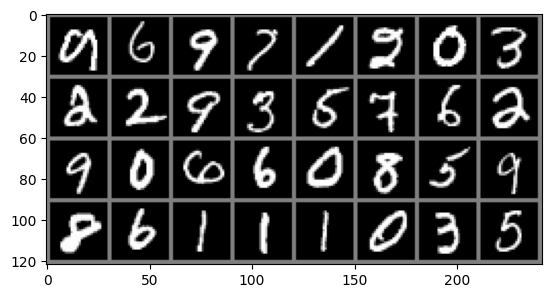

Test loader batch size: 64


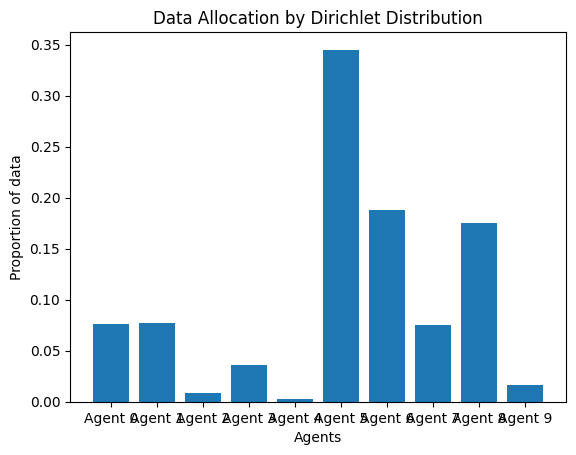

In [157]:
train_loaders, val_loaders, test_loader = import_dataLoaders('MNIST', plot=True )

In [155]:
torch.cuda.manual_seed(42)
system = Agents(train_loaders, val_loaders, test_loader, L, num_agents,epochs=10, gamma_zero = 0.5, symmetry=True, lr=0.01)
system.train_FedAvg()
Favg_acc = system.test_agent(0)

100%|██████████| 10/10 [02:45<00:00, 16.50s/it]


Agent 0  Test Accuracy: 91.29% 


Processing NEXT training with neighborhood: 100%|██████████| 20/20 [05:00<00:00, 15.04s/it]


 
 Average params difference equal to 0.0006659797509200871


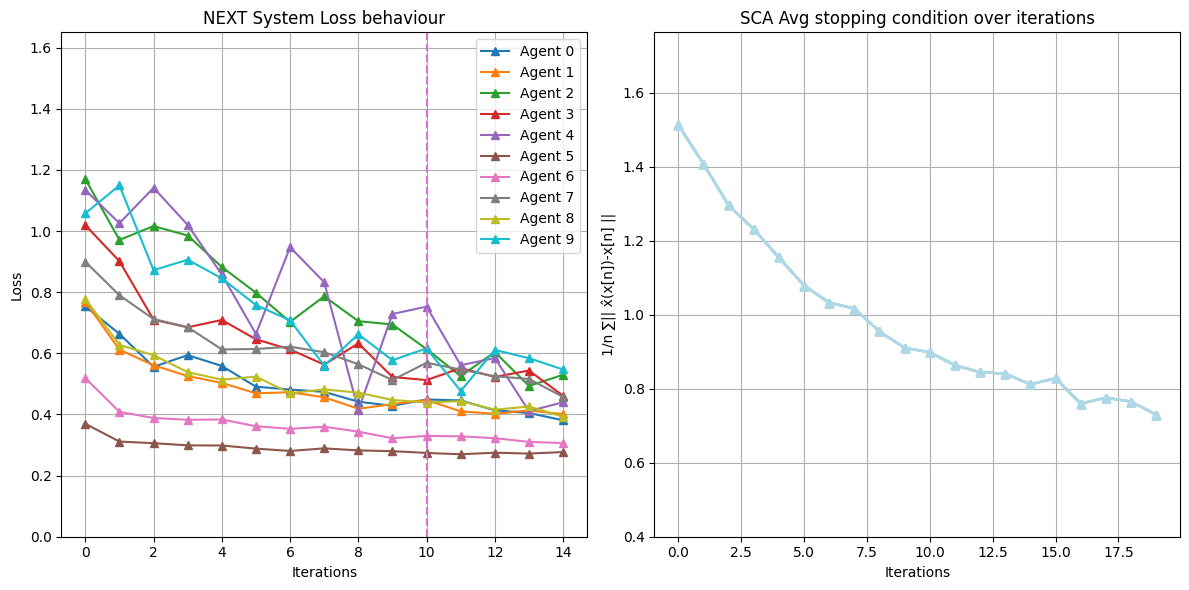

Agent 2  Test Accuracy: 88.99% 
Algorithm converge after 6 iterations


In [153]:
torch.cuda.manual_seed(42)
torch.manual_seed
system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, epochs=20, iterations = 50, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=True)
system.NEXT_train(dataset='MNIST',tolerance=1e-3, symmetry=True, fraction=.75)
MNIST_sym_acc = system.test_agent(2)
sym_stop = system.stopping_iter
mnist_sym_h = system.plot_disagreement(plot=False)
mnist_sym_w= system.W
print(f"Algorithm converge after {sym_stop} iterations")

In [147]:
print(mnist_sym_w[0,1]== mnist_sym_w[1,0])
print(system.W)

tensor(True)
tensor([[0.4007, 0.0749, 0.0749, 0.0749, 0.0749, 0.0749, 0.0749, 0.0000, 0.0749,
         0.0749],
        [0.0749, 0.3258, 0.0749, 0.0749, 0.0749, 0.0749, 0.0749, 0.0749, 0.0749,
         0.0749],
        [0.0749, 0.0749, 0.4756, 0.0749, 0.0000, 0.0749, 0.0000, 0.0749, 0.0749,
         0.0749],
        [0.0749, 0.0749, 0.0749, 0.4756, 0.0000, 0.0749, 0.0749, 0.0749, 0.0000,
         0.0749],
        [0.0749, 0.0749, 0.0000, 0.0000, 0.6255, 0.0000, 0.0749, 0.0749, 0.0000,
         0.0749],
        [0.0749, 0.0749, 0.0749, 0.0749, 0.0000, 0.5506, 0.0749, 0.0000, 0.0749,
         0.0000],
        [0.0749, 0.0749, 0.0000, 0.0749, 0.0749, 0.0749, 0.4007, 0.0749, 0.0749,
         0.0749],
        [0.0000, 0.0749, 0.0749, 0.0749, 0.0749, 0.0000, 0.0749, 0.4756, 0.0749,
         0.0749],
        [0.0749, 0.0749, 0.0749, 0.0000, 0.0000, 0.0749, 0.0749, 0.0749, 0.4756,
         0.0749],
        [0.0749, 0.0749, 0.0749, 0.0749, 0.0749, 0.0000, 0.0749, 0.0749, 0.0749,
         0.4007

Processing NEXT training with neighborhood: 100%|██████████| 20/20 [04:32<00:00, 13.65s/it]


 
 Average params difference equal to 0.0008424302795901895


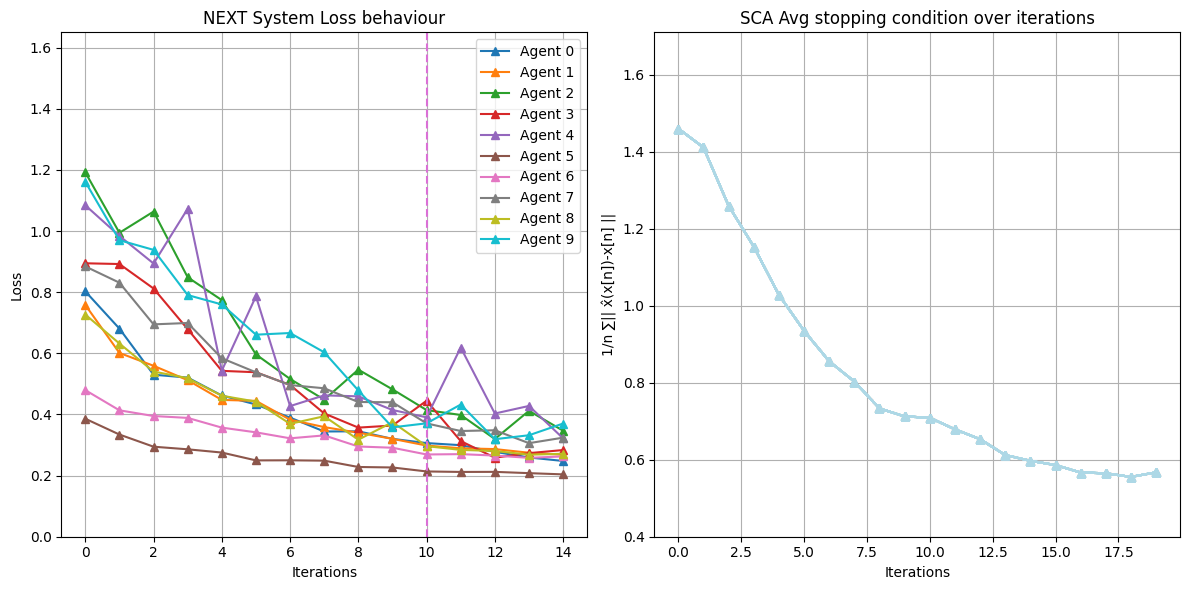

Agent 2  Test Accuracy: 87.56% 


In [124]:
torch.cuda.manual_seed(42)
torch.manual_seed
system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, epochs=20 , iterations = 50, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=False)
system.NEXT_train(dataset='MNIST',tolerance=1e-3, symmetry=False, fraction=.75)
MNIST_Nsym_acc = system.test_agent(2)
Nsym_stop = system.stopping_iter
mnist_Nsym_h = system.plot_disagreement(plot=False)
mnist_Nsym_w= system.W

In [125]:
print(mnist_Nsym_w[0,1]== mnist_sym_w[1,0])
print(system.W)

tensor(False)
tensor([[3.2000e-01, 1.5274e-02, 1.3985e-04, 2.3378e-03, 7.6077e-04, 6.1289e-01,
         2.1230e-03, 0.0000e+00, 4.6475e-02, 2.6157e-06],
        [7.2177e-02, 8.0169e-02, 1.6875e-04, 2.8210e-03, 9.1798e-04, 7.3955e-01,
         2.5617e-03, 4.5555e-02, 5.6079e-02, 3.1563e-06],
        [7.7138e-02, 1.9698e-02, 1.1452e-03, 3.0149e-03, 0.0000e+00, 7.9038e-01,
         0.0000e+00, 4.8686e-02, 5.9933e-02, 3.3732e-06],
        [8.0522e-02, 2.0562e-02, 1.8827e-04, 1.9984e-02, 0.0000e+00, 8.2506e-01,
         2.8579e-03, 5.0822e-02, 0.0000e+00, 3.5212e-06],
        [4.9304e-01, 1.2590e-01, 0.0000e+00, 0.0000e+00, 5.2359e-02, 0.0000e+00,
         1.7499e-02, 3.1118e-01, 0.0000e+00, 2.1560e-05],
        [1.2917e-02, 3.2985e-03, 3.0201e-05, 5.0485e-04, 0.0000e+00, 9.7275e-01,
         4.5846e-04, 0.0000e+00, 1.0036e-02, 0.0000e+00],
        [7.6037e-02, 1.9416e-02, 0.0000e+00, 2.9718e-03, 9.6708e-04, 7.7910e-01,
         1.4437e-02, 4.7991e-02, 5.9078e-02, 3.3250e-06],
        [0.00

Processing NEXT training with neighborhood: 100%|██████████| 20/20 [04:20<00:00, 13.03s/it]


 
 Average params difference equal to 0.0008933289209380746


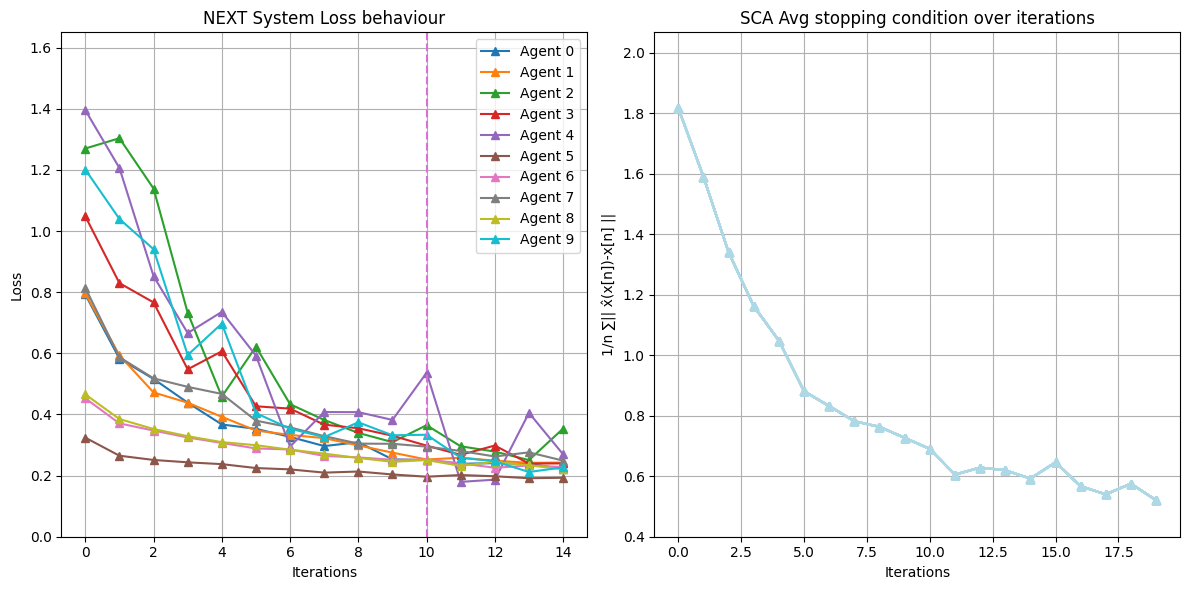

Agent 2  Test Accuracy: 94.13% 
Diffuaion matrix is tensor([[5.2897e-01, 1.2894e-03, 7.3660e-05, 3.6200e-02, 1.0460e-05, 3.2567e-01,
         2.9275e-02, 0.0000e+00, 7.8512e-02, 3.2941e-07],
        [1.5830e-01, 8.9788e-03, 1.1793e-04, 5.7954e-02, 1.6746e-05, 5.2139e-01,
         4.6867e-02, 8.0682e-02, 1.2569e-01, 5.2737e-07],
        [1.6719e-01, 2.1801e-03, 7.9085e-04, 6.1208e-02, 0.0000e+00, 5.5067e-01,
         0.0000e+00, 8.5213e-02, 1.3275e-01, 5.5699e-07],
        [1.3445e-01, 1.7532e-03, 1.0016e-04, 3.1254e-01, 0.0000e+00, 4.4283e-01,
         3.9805e-02, 6.8525e-02, 0.0000e+00, 4.4791e-07],
        [5.4955e-01, 7.1661e-03, 0.0000e+00, 0.0000e+00, 4.8541e-04, 0.0000e+00,
         1.6270e-01, 2.8010e-01, 0.0000e+00, 1.8308e-06],
        [3.7484e-02, 4.8880e-04, 2.7924e-05, 1.3723e-02, 0.0000e+00, 9.0741e-01,
         1.1098e-02, 0.0000e+00, 2.9764e-02, 0.0000e+00],
        [1.3226e-01, 1.7247e-03, 0.0000e+00, 4.8423e-02, 1.3992e-05, 4.3564e-01,
         2.0949e-01, 6.7413e-02, 

In [158]:
torch.cuda.manual_seed(42)
torch.manual_seed
system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, epochs=20, iterations = 100, pie = [1.0,.5,10], gamma_zero = 0.5, symmetry=False)
system.NEXT_train(dataset='MNIST',tolerance=1e-3, symmetry=False, fraction=.75)
mnist_bio_acc = system.test_agent(2)
bio_stop = system.stopping_iter
mnist_bio_h = system.plot_disagreement(plot=False)
print(f"Diffuaion matrix is {system.W}")

In [ ]:
# pie_1_values = [1.0]
# pie_2_values = np.linspace(0.1, 0.5, 5).tolist()
# pie_3_values = [10]

# torch.cuda.manual_seed(42)
# # Use itertools.product to generate all combinations of these values
# pie_grid = list(itertools.product(pie_1_values, pie_2_values, pie_3_values))
# best_acc = 0.0
# best_pie=None
# stop_bio=0

# for pi in pie_grid:
#   print(f"Evaluating params {pi}")
#   system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, temp=2, epochs=20, iterations = 100, pie = pi, gamma_zero = 0.5, symmetry=False, lr=0.01)
#   system.NEXT_train(dataset='MNIST',tolerance=1e-3, symmetry=False, plot=True, fraction=1)
#   test_acc = system.test_agent(0)
#   bio_stop = system.stopping_iter
#   best_bio_h = system.plot_disagreement(plot=False)

#   if test_acc>best_acc and bio_stop <= stop_bio:
#     best_acc = test_acc
#     best_pie = pi
#     stop_bio = bio_stop
#     mnist_bio_h= best_bio_h
# print(f"Best pie is {best_pie} with accuracy {best_acc}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mnist_sym_h, label='Symmetric', marker='o', color='lightblue', linestyle='--')
plt.plot(mnist_bio_h, label='Bio-Inspired', marker='x', color='green', linestyle='--')
plt.plot(mnist_Nsym_h, label='Non-sym', marker='^', color='orchid', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Disagreement')
plt.title('Disagreement Comparison on MNIST')
plt.grid()
plt.legend()
plt.show()

In [16]:

def plot_graph_with_diffusion(diffusion_matrix, fixed_pos=None):
    """
    Plots a graph where the nodes are colored in shades of red and edges in Wistia (yellow/orange scale)
    based on importance values.

    Parameters:
    diffusion_matrix (numpy.ndarray): A square matrix representing the diffusion or
                                      importance values between nodes.
    fixed_pos (dict): Optional. A dictionary of fixed positions for nodes. If provided,
                      the graph will be plotted using these positions.
    """
    # Create a graph
    G = nx.Graph()

    # Add nodes and edges with weights (from diffusion matrix)
    num_nodes = diffusion_matrix.shape[0]
    for i in range(num_nodes):
        G.add_node(i, importance=diffusion_matrix[i, i])  # Add importance for each node
        for j in range(i + 1, num_nodes):
            if diffusion_matrix[i, j] > 0:  # Add edge if there's a connection
                G.add_edge(i, j, weight=diffusion_matrix[i, j])

    # Node importance (diagonal of diffusion matrix) will be mapped to node colors
    node_importance = np.diag(diffusion_matrix)

    # Edge weights will be mapped to edge colors
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    # Normalize node importance and edge weights for coloring
    if np.max(node_importance) > 0:
        node_color_map = node_importance / np.max(node_importance)
    else:
        node_color_map = node_importance  # If all are 0, keep original values

    if np.max(edge_weights) > 0:
        edge_color_map = edge_weights / np.max(edge_weights)
    else:
        edge_color_map = edge_weights  # If all are 0, keep original values

    # Apply red colormap to nodes (Reds)
    node_colors = plt.cm.Reds(node_color_map)  # Map the normalized node importance to Reds colormap

    # Apply Wistia colormap to edges
    edge_colors = plt.cm.Wistia(edge_color_map)  # Map the normalized edge weights to Wistia colormap

    # Create a larger plot (bigger figure for the graph)
    fig, ax = plt.subplots(figsize=(12, 12))  # Use subplots to manage axes

    # Determine positions of nodes
    if fixed_pos is None:
        pos = nx.spring_layout(G, seed=42)  # Use a fixed seed to make the layout reproducible
    else:
        pos = fixed_pos  # Use provided fixed positions

    # Draw the graph
    # Draw nodes with color intensity based on importance using Reds colormap
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, ax=ax)

    # Draw edges with colors mapped from Wistia colormap
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2, ax=ax)

    # Add labels
    nx.draw_networkx_labels(G, pos, ax=ax)

    # Create specific axes for colorbars
    cbar_ax_nodes = fig.add_axes([0.92, 0.55, 0.02, 0.3])  # Position the node colorbar
    cbar_ax_edges = fig.add_axes([0.92, 0.1, 0.02, 0.3])   # Position the edge colorbar

    # Show colorbars for node and edge importance
    sm_nodes = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=np.min(node_color_map), vmax=np.max(node_color_map)))
    sm_nodes.set_array([])
    cbar_nodes = plt.colorbar(sm_nodes, cax=cbar_ax_nodes)  # Assign to the specific axes
    cbar_nodes.ax.tick_params(labelsize=8)  # Smaller font size for the legend
    cbar_nodes.set_label("Node Importance", fontsize=10)

    sm_edges = plt.cm.ScalarMappable(cmap=plt.cm.Wistia, norm=plt.Normalize(vmin=np.min(edge_color_map), vmax=np.max(edge_color_map)))
    sm_edges.set_array([])
    cbar_edges = plt.colorbar(sm_edges, cax=cbar_ax_edges)  # Assign to the specific axes
    cbar_edges.ax.tick_params(labelsize=8)  # Smaller font size for the legend
    cbar_edges.set_label("Edge Importance", fontsize=10)

    # Show plot
    plt.axis('off')
    plt.show()

    return pos  # Retu

# First plot: calculate and save positions
#fixed_positions = plot_graph_with_diffusion(mnist_Nsym_w)

# # Subsequent plots: reuse the same fixed positions
# plot_graph_with_diffusion(diffusion_matrix, fixed_pos=fixed_positions)


## FASHION MNIST

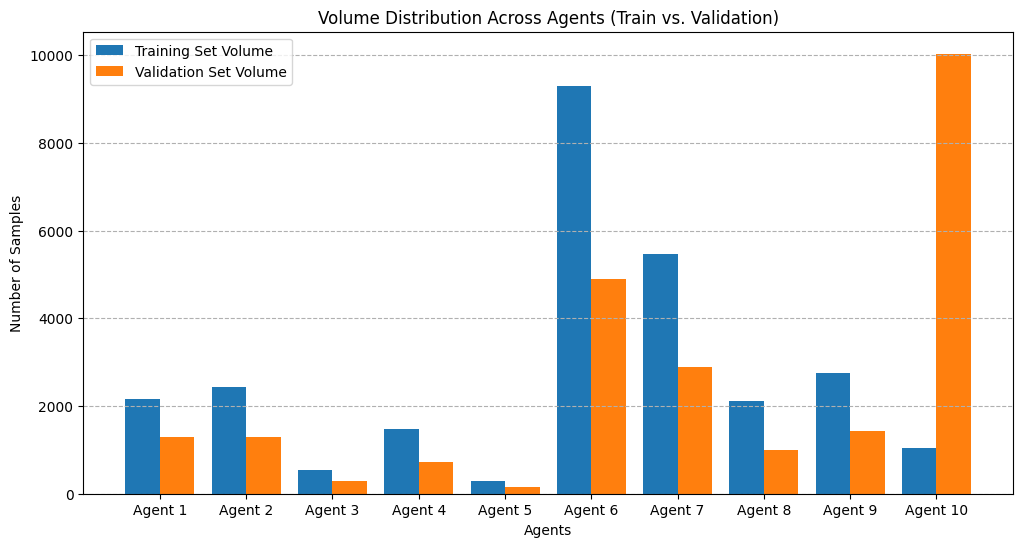

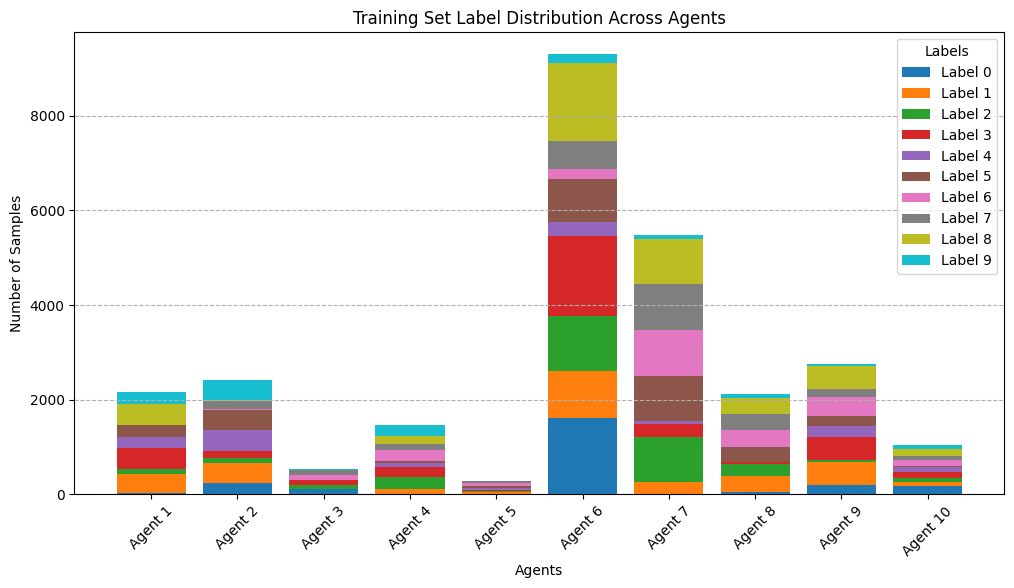

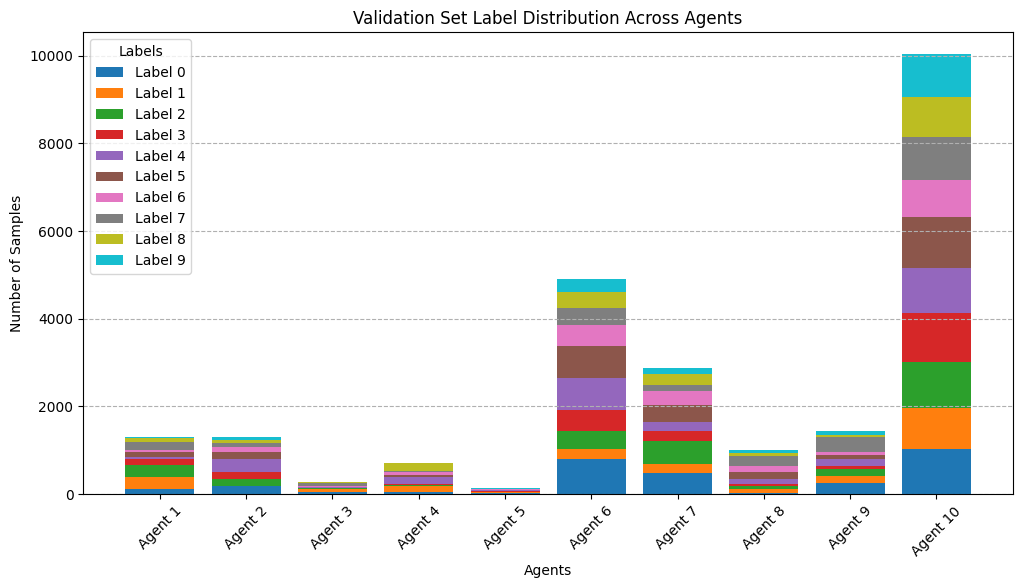

In [220]:
train_loaders, val_loaders, test_loader = import_dataLoaders('FASHION',plot=True, label_het_train=.48)

Processing NEXT training with neighborhood: 100%|██████████| 15/15 [02:33<00:00, 10.25s/it]


 
 Average params difference equal to 0.0007178261294029653


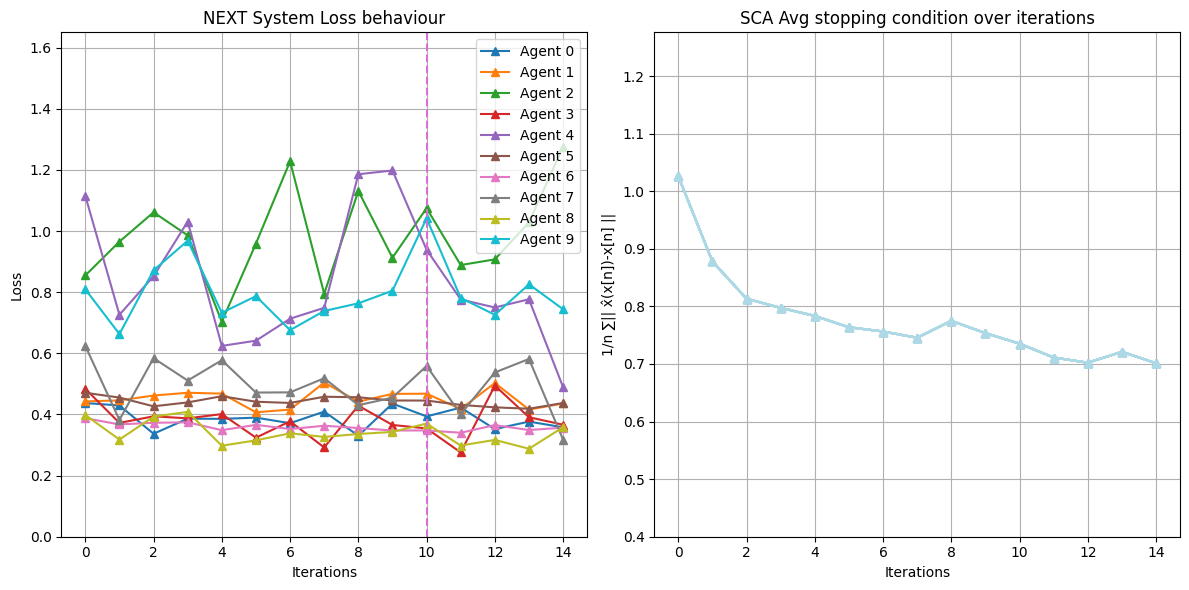

Agent 0  Test Accuracy: 49.32% 


In [213]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, dataset='FASHION', epochs=15, iterations = 100, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=True, lr=0.01)
system.NEXT_train(dataset = 'FASHION', tolerance=1e-3, symmetry=True, fraction=.75)
fashion_sym_acc = system.test_agent(0)
fashion_sym_stop = system.stopping_iter
fashion_sym_h= system.plot_disagreement(plot=False)



Processing NEXT training with neighborhood: 100%|██████████| 15/15 [03:16<00:00, 13.07s/it]


 
 Average params difference equal to 0.0007625605212524533


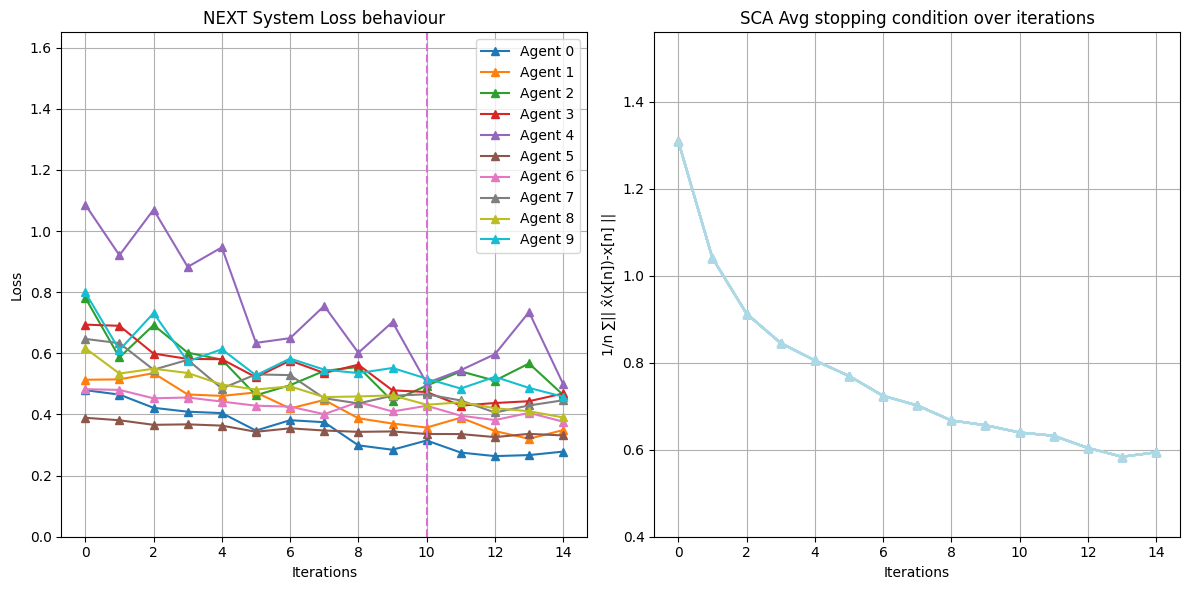

Agent 2  Test Accuracy: 73.24% 


In [221]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, dataset='FASHION', epochs=15, iterations = 100, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=False)
system.NEXT_train(dataset = 'FASHION', tolerance=1e-3, symmetry=False, fraction=.25)
fashion_Nsym_acc = system.test_agent(2)
fashion_Nsym_stop = system.stopping_iter
fashion_Nsym_h= system.plot_disagreement(plot=False)
fashion_Nsym_w = system.W


Processing NEXT training with neighborhood:  60%|██████    | 9/15 [02:14<01:29, 14.99s/it]

 
 Average params difference equal to 0.0008037597290240228
Convergence reached in 9 iterations.


 
 Average params difference equal to 0.0007152165635488927


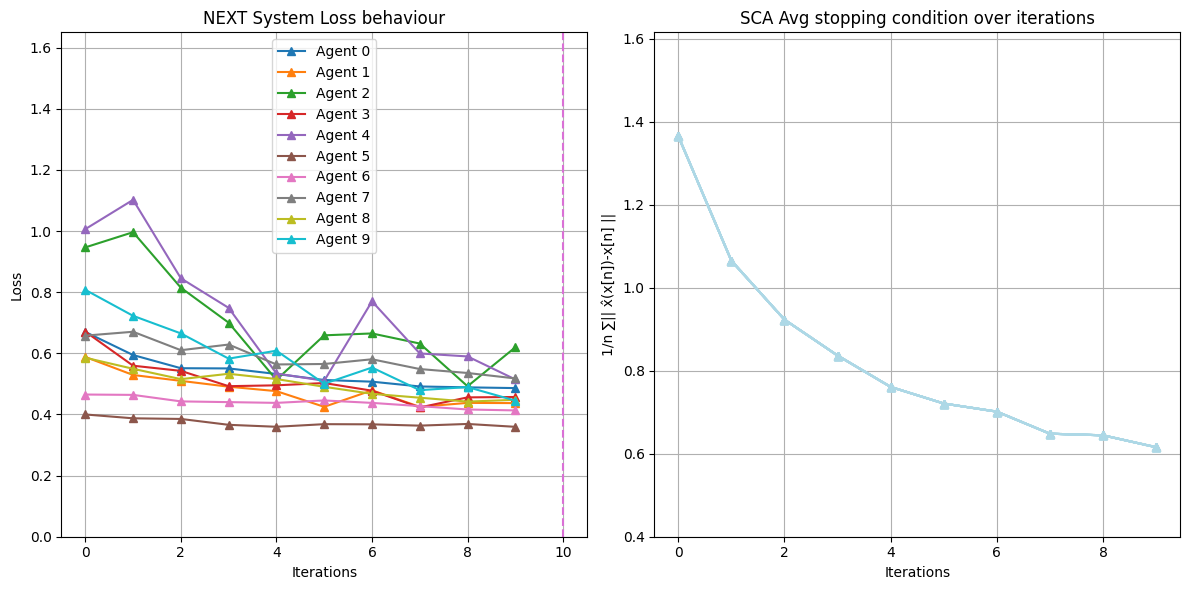

Agent 2  Test Accuracy: 73.13% 


In [218]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, dataset='FASHION', epochs=15, iterations = 150, pie = [1.0,0.5,10], gamma_zero = 0.5, symmetry=False)
system.NEXT_train(dataset = 'FASHION', tolerance=1e-3, symmetry=False, fraction=1)
fashion_bio_acc = system.test_agent(2)
fashion_bio_stop = system.stopping_iter
fashion_bio_h= system.plot_disagreement(plot=False)
fashion_bio_w = system.W

In [ ]:
# torch.cuda.manual_seed(42)
# pie_1_values = [1.0]
# pie_2_values = np.linspace(0.1, 0.5, 5).tolist()
# pie_3_values = [10]

# # Use itertools.product to generate all combinations of these values
# pie_grid = list(itertools.product(pie_1_values, pie_2_values, pie_3_values))
# best_acc = 0.0
# best_pie=None
# fashion_stop_bio=0

# for pi in pie_grid:
#   print(f"Evaluating params {pi}")
#   system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, temp=2,  epochs=20, iterations = 100, pie = pi, gamma_zero = 0.5, symmetry=False, lr=0.01)
#   system.NEXT_train(dataset = 'FASHION', tolerance=1e-3, symmetry=False, plot=True, fraction=0.5)
#   test_acc = system.test_agent(2)
#   bio_stop = system.stopping_iter
#   fashion_bio_h = system.plot_disagreement(plot=False)
#   if pi[1]==0.0:
#     fashion_Nsym_acc = test_acc
#     fashion_Nsym_stop = bio_stop
#     fashion_Nsym_h = fashion_bio_h

#   elif test_acc> best_acc and bio_stop <= fashion_stop_bio:
#     fashion_bio_acc = test_acc
#     best_pie = pi
#     fashion_stop_bio = bio_stop
#     fashion_best_h = fashion_bio_h
# print(f"Best pie is {best_pie} with accuracy {fashion_bio_acc}")

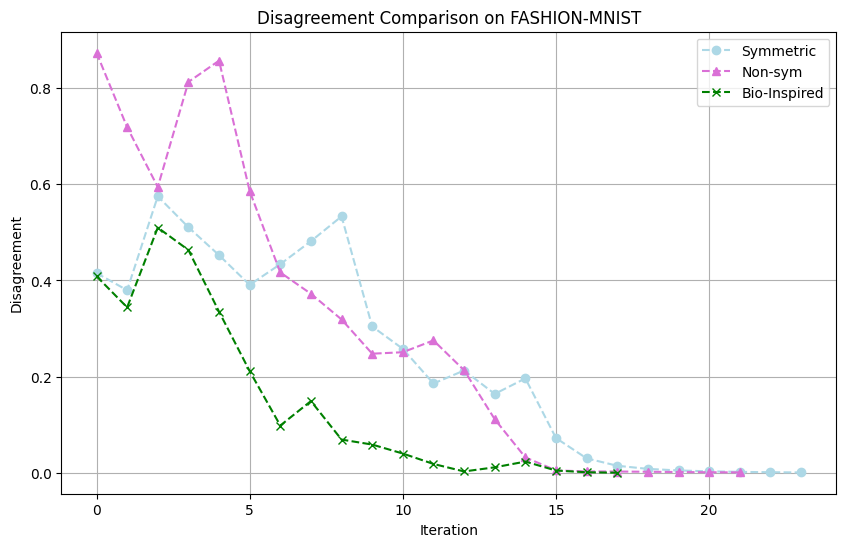

In [223]:
plt.figure(figsize=(10, 6))
plt.plot(fashion_sym_h[:25], label='Symmetric', marker='o', color='lightblue', linestyle='--')
plt.plot(fashion_Nsym_h[:25], label='Non-sym', marker='^', color='orchid', linestyle='--')
plt.plot(fashion_bio_h[:25], label='Bio-Inspired', marker='x', color='green', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Disagreement')
plt.title('Disagreement Comparison on FASHION-MNIST')
plt.grid()
plt.legend()
plt.show()

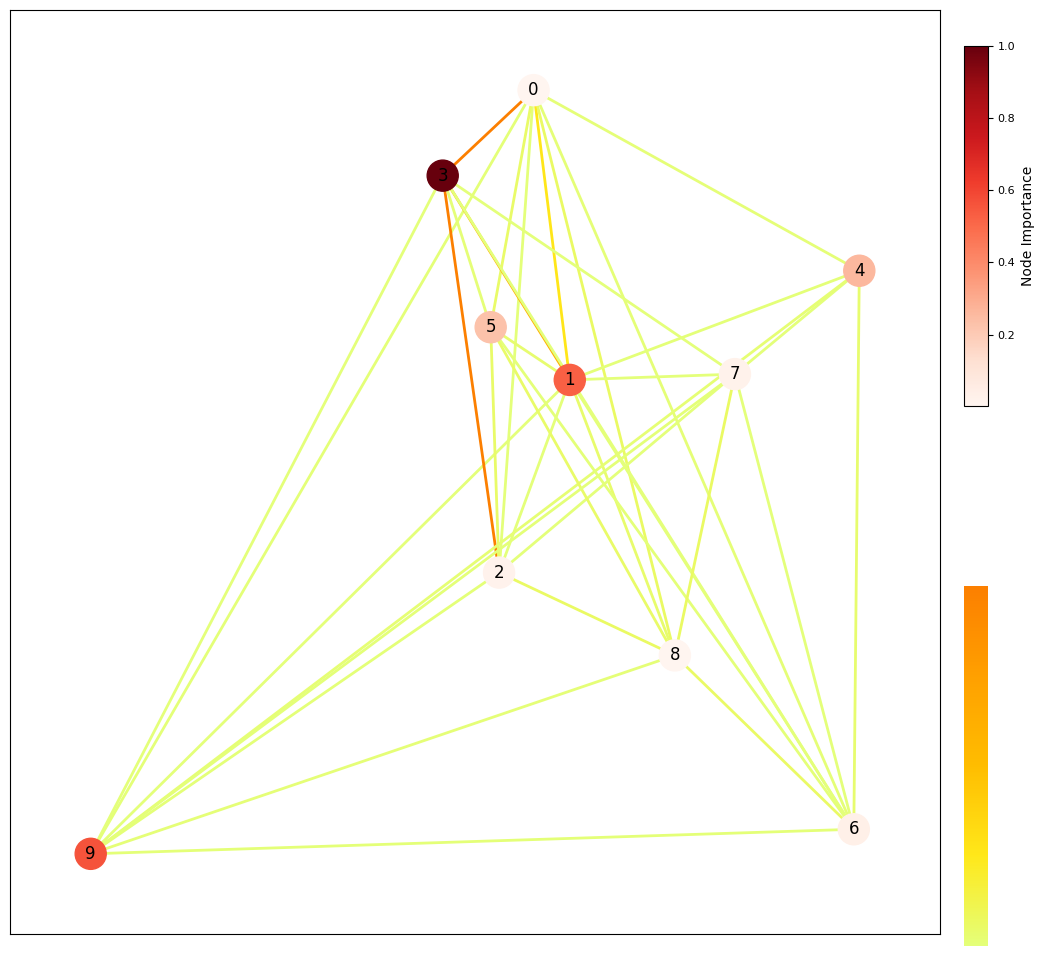

{0: array([-0.08542913,  0.26551439]),
 1: array([-0.01066655,  0.05342115]),
 2: array([-0.15667189, -0.08762066]),
 3: array([-0.27307943,  0.20295566]),
 4: array([0.58722663, 0.13333263]),
 5: array([-0.17398688,  0.09199637]),
 6: array([ 0.5758799 , -0.27552689]),
 8: array([ 0.20635206, -0.14823272]),
 9: array([-1.        , -0.29349316]),
 7: array([0.3303753 , 0.05765323])}

In [224]:
plot_graph_with_diffusion(fashion_bio_w, fixed_pos=fixed_positions)

In [ ]:
# torch.cuda.manual_seed(42)

# system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, epochs=10, dataset='MNIST', gamma_zero = 0.5, symmetry=True, lr=0.01)
# system.train_FedAvg()
# fashion_Favg_acc = system.test_agent(0)

In [ ]:
# # Save the variables to a text file
# with open("fashion_results_final.txt", "w") as file:
#     file.write(f"Faveragin_cifar: {fashion_Favg_acc}\n")
#     file.write(f"symmetric_stopping: {fashion_sym_stop}\n")
#     file.write(f"symmetric_accyracy: {fashion_sym_acc}\n")
#     file.write(f"non symmetric_stopping: {fashion_Nsym_stop}\n")
#     file.write(f"non symmetric_accyracy: {fashion_Nsym_acc}\n")
#     file.write(f"bio_stopping: {fashion_stop_bio}\n")
#     file.write(f"bio_accyracy: {fashion_bio_acc}\n")

## SVHN Results

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


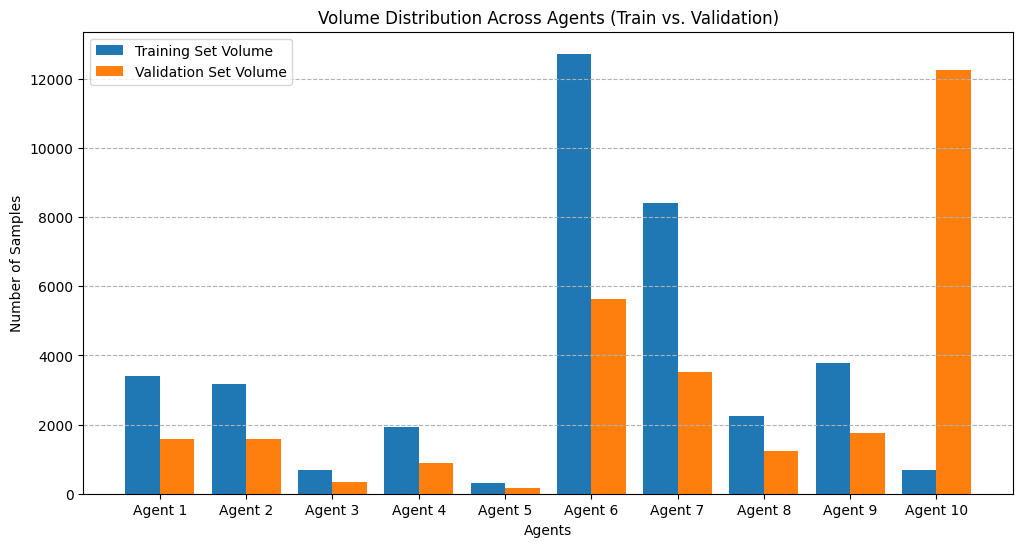

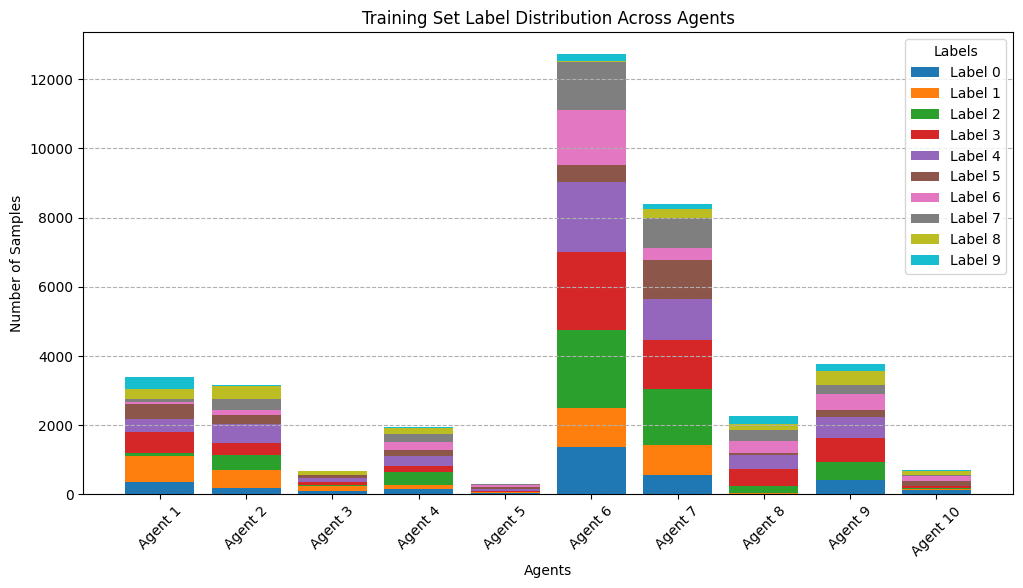

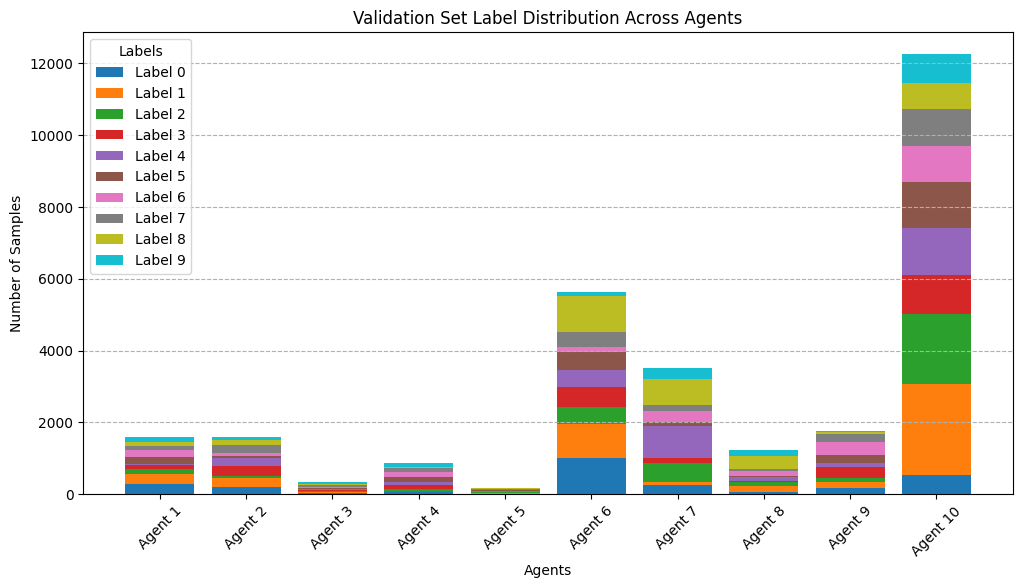

In [26]:
train_loaders, val_loaders, test_loader = import_dataLoaders('SVHN',label_het_train=.8)

Processing NEXT training with neighborhood: 100%|██████████| 15/15 [03:40<00:00, 14.71s/it]


 
 Average params difference equal to 0.000841924746055156


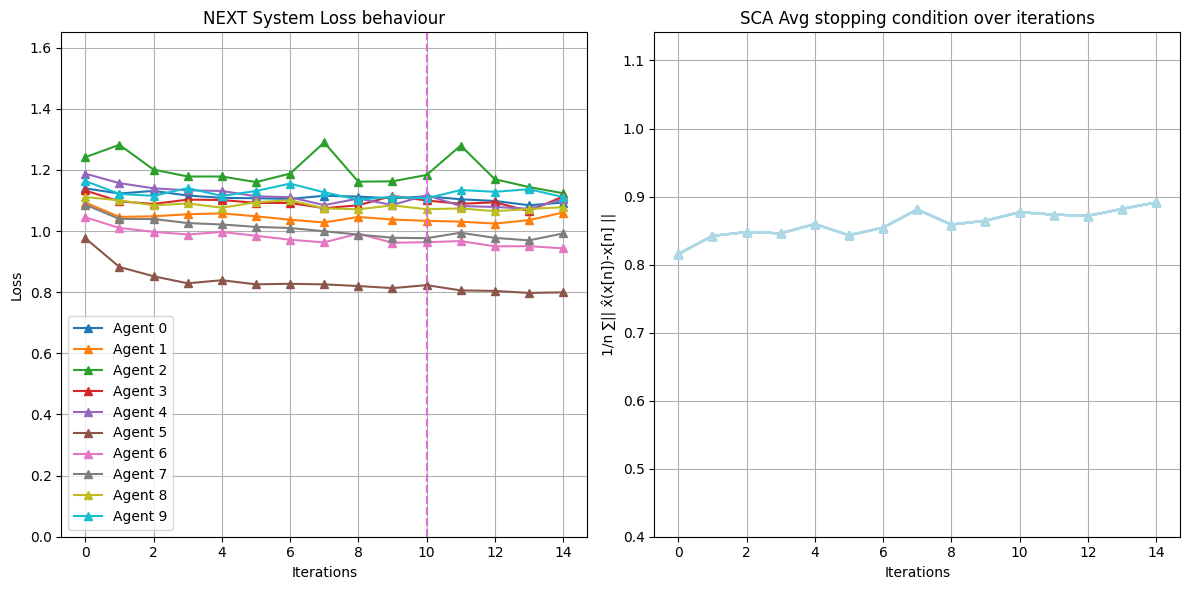

Agent 0  Test Accuracy: 13.61% 


In [19]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, dataset='SVHN', epochs=15, iterations = 100, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=True, lr=0.01)
system.NEXT_train(dataset = 'SVHN', tolerance=1e-3, symmetry=True, fraction=.5)
svhn_sym_acc = system.test_agent(0)
svhn_sym_stop = system.stopping_iter
svhn_sym_h = system.plot_disagreement(plot=False)


Processing NEXT training with neighborhood: 100%|██████████| 15/15 [03:41<00:00, 14.76s/it]


 
 Average params difference equal to 0.00038239406421780586


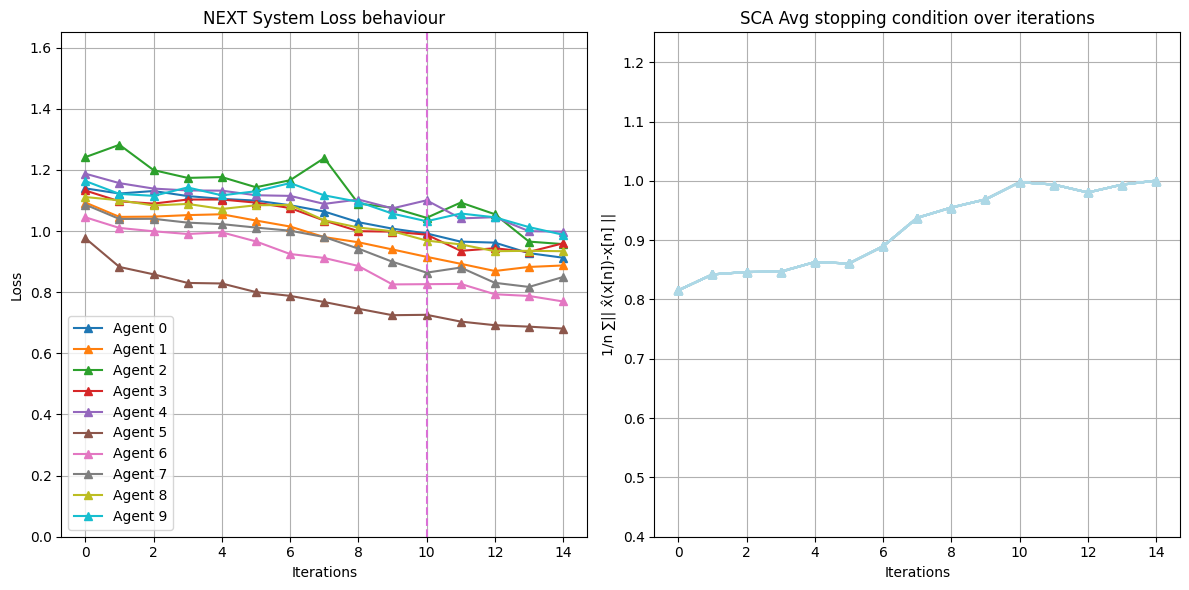

Agent 0  Test Accuracy: 39.74% 


In [22]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, dataset='SVHN', epochs=15, iterations = 250, pie = [1.0,0.0,10], gamma_zero = 0.5, symmetry=False, lr=0.01)
system.NEXT_train(dataset = 'SVHN', tolerance=1e-3, symmetry=False, fraction=.5)
svhn_Nsym_acc = system.test_agent(0)
svhn_Nsym_stop = system.stopping_iter
svhn_Nsym_h = system.plot_disagreement(plot=False)

Processing NEXT training with neighborhood: 100%|██████████| 15/15 [04:09<00:00, 16.64s/it]


 
 Average params difference equal to 0.0008129618945531547


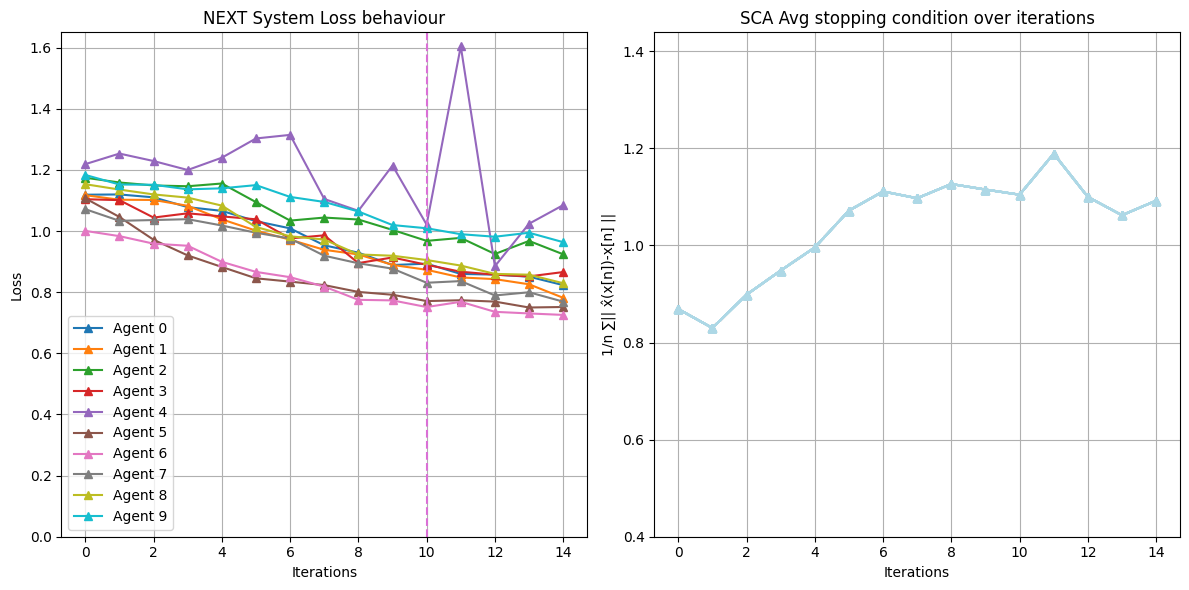

Agent 0  Test Accuracy: 42.34% 


In [11]:
torch.cuda.manual_seed(42)

system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, dataset='SVHN', epochs=15, iterations = 100, pie = [1.0,0.5,10], gamma_zero = 0.5, symmetry=False, lr=0.01)
system.NEXT_train(dataset = 'SVHN', tolerance=1e-3, symmetry=False, fraction=0.5)
svhn_bio_acc = system.test_agent(0)
svhn_bio_stop = system.stopping_iter
svhn_bio_h = system.plot_disagreement(plot=False)

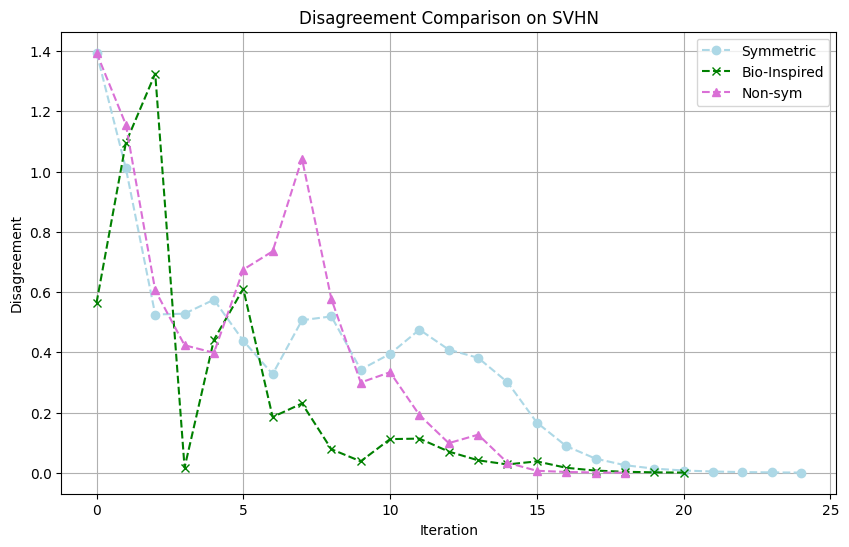

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(svhn_sym_h[:35], label='Symmetric', marker='o', color='lightblue', linestyle='--')
plt.plot(svhn_bio_h[:35], label='Bio-Inspired', marker='x', color='green', linestyle='--')
plt.plot(svhn_Nsym_h[:35], label='Non-sym', marker='^', color='orchid', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Disagreement')
plt.title('Disagreement Comparison on SVHN')
plt.grid()
plt.legend()
plt.show()

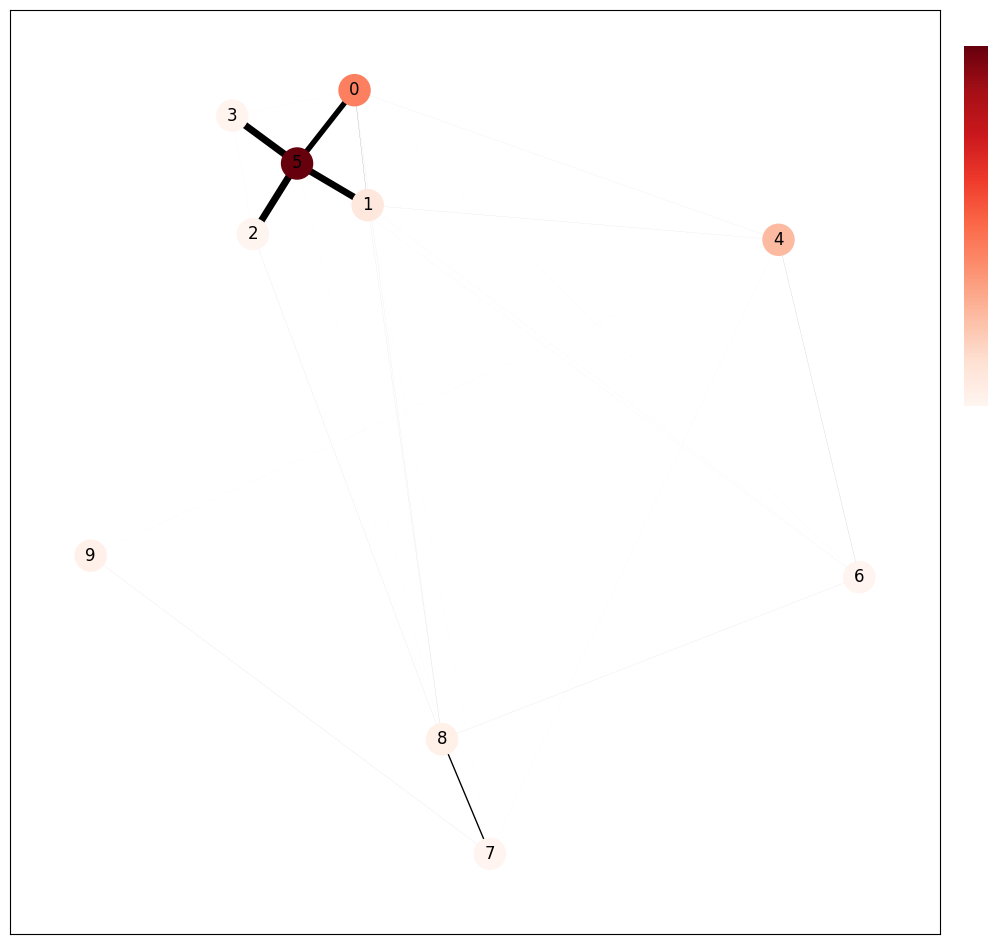

{0: array([-0.13596634,  0.60298136]),
 1: array([-0.10712386,  0.36156535]),
 2: array([-0.35891529,  0.30086993]),
 3: array([-0.4043684 ,  0.54930225]),
 4: array([0.79456853, 0.28892282]),
 5: array([-0.26213607,  0.44908573]),
 6: array([ 0.97185805, -0.41903199]),
 8: array([ 0.05597951, -0.75962885]),
 9: array([-0.71502969, -0.37406661]),
 7: array([ 0.16113355, -1.        ])}

In [32]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph_with_diffusion(diffusion_matrix, fixed_pos=None):
    """
    Plots a graph where the nodes are colored in shades of red and edges are black,
    with edge width based on importance values.

    Parameters:
    diffusion_matrix (numpy.ndarray): A square matrix representing the diffusion or
                                      importance values between nodes.
    fixed_pos (dict): Optional. A dictionary of fixed positions for nodes. If provided,
                      the graph will be plotted using these positions.
    """
    # Create a graph
    G = nx.Graph()

    # Add nodes and edges with weights (from diffusion matrix)
    num_nodes = diffusion_matrix.shape[0]
    for i in range(num_nodes):
        G.add_node(i, importance=diffusion_matrix[i, i])  # Add importance for each node
        for j in range(i + 1, num_nodes):
            if diffusion_matrix[i, j] > 0:  # Add edge if there's a connection
                G.add_edge(i, j, weight=diffusion_matrix[i, j])

    # Node importance (diagonal of diffusion matrix) will be mapped to node colors
    node_importance = np.diag(diffusion_matrix)

    # Edge weights will be used for edge width
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

    # Normalize node importance and edge weights for coloring and edge width (log scaling for mitigation)
    node_color_map = np.log1p(node_importance) / np.log1p(np.max(node_importance)) if np.max(node_importance) > 0 else node_importance
    edge_widths = np.log1p(edge_weights) / np.log1p(np.max(edge_weights)) * 5  # Scale for visual clarity (multiplied by 5)

    # Apply red colormap to nodes (Reds)
    node_colors = plt.cm.Reds(node_color_map)  # Map the log-scaled node importance to Reds colormap

    # Create a larger plot (bigger figure for the graph)
    fig, ax = plt.subplots(figsize=(12, 12))  # Use subplots to manage axes

    # Determine positions of nodes
    if fixed_pos is None:
        pos = nx.spring_layout(G, seed=42)  # Use a fixed seed to make the layout reproducible
    else:
        pos = fixed_pos  # Use provided fixed positions

    # Draw the graph
    # Draw nodes with color intensity based on importance using Reds colormap
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, ax=ax)

    # Draw edges in black with varying width based on importance
    nx.draw_networkx_edges(G, pos, edge_color='black', width=edge_widths, ax=ax)

    # Add labels
    nx.draw_networkx_labels(G, pos, ax=ax)

    # Create specific axes for colorbars
    cbar_ax_nodes = fig.add_axes([0.92, 0.55, 0.02, 0.3])  # Position the node colorbar

    # Show colorbar for node importance (since edges are black, no colorbar for edges)
    sm_nodes = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=np.min(node_color_map), vmax=np.max(node_color_map)))
    sm_nodes.set_array([])
    cbar_nodes = plt.colorbar(sm_nodes, cax=cbar_ax_nodes)  # Assign to the specific axes
    cbar_nodes.ax.tick_params(labelsize=8)  # Smaller font size for the legend
    cbar_nodes.set_label("Node Importance", fontsize=10)

    # Show plot
    plt.axis('off')
    plt.show()

    return pos  # Return the positions for reuse in future plots

# Example usage with a sample diffusion matrix
diffusion_matrix = np.random.rand(10, 10)  # Replace this with your actual matrix


# Subsequent plots: reuse the same fixed positions
plot_graph_with_diffusion(system.W)
plot_graph_with_diffusion()


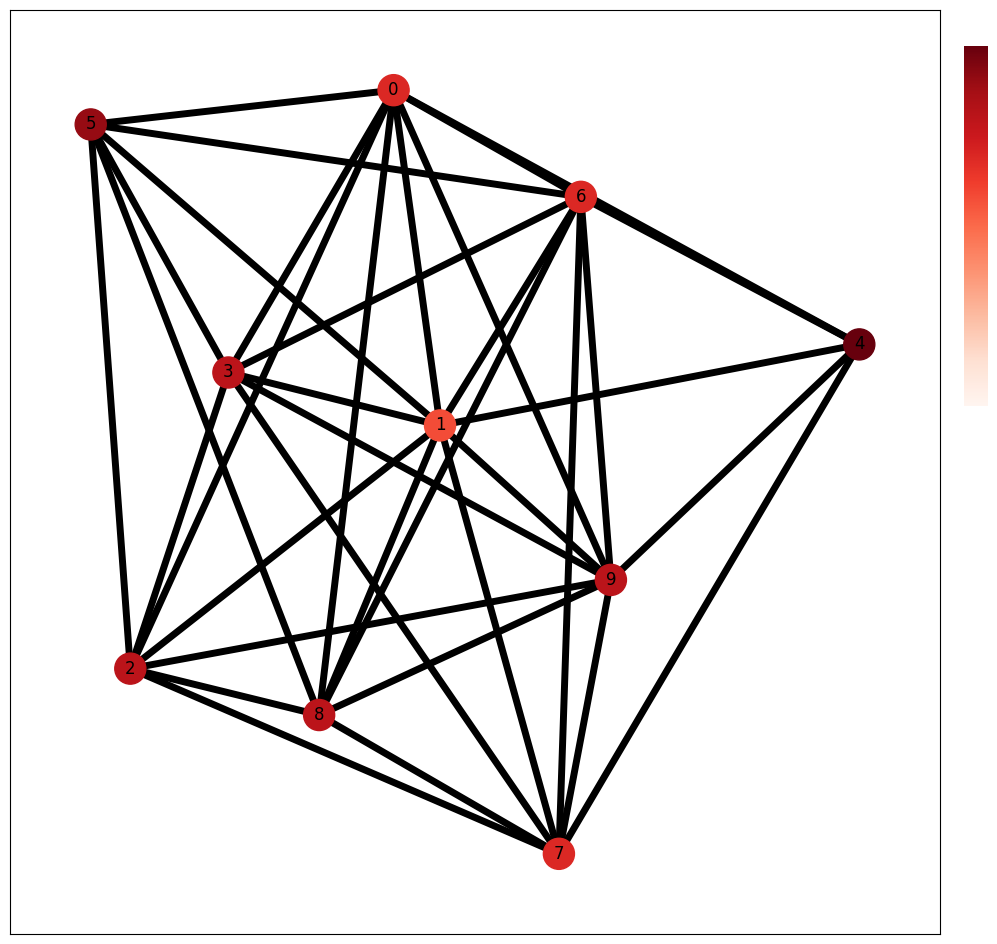

{0: array([-0.06304945,  0.5452722 ]),
 1: array([0.04293391, 0.01836371]),
 2: array([-0.66403885, -0.36385281]),
 3: array([-0.4400994 ,  0.10156691]),
 4: array([1.        , 0.14570709]),
 5: array([-0.7544631 ,  0.49142754]),
 6: array([0.36443175, 0.37761991]),
 8: array([-0.23301384, -0.43678743]),
 9: array([ 0.43299547, -0.2243904 ]),
 7: array([ 0.31430352, -0.65492672])}

In [34]:
system= Agents(train_loaders, val_loaders, test_loader, L, num_agents, epochs=10, dataset='SVHN', gamma_zero = 0.5, symmetry=True, lr=0.01)
plot_graph_with_diffusion(system.W,)

In [ ]:
# torch.cuda.manual_seed(42)

# system = Agents(train_loaders, val_loaders, test_loader, L, num_agents, epochs=10, dataset='SVHN', gamma_zero = 0.5, symmetry=True, lr=0.01)
# system.train_FedAvg()
# svhn_Favg_acc = system.test_agent(0)

## Numerical Comparisons

In [ ]:
# df = pd.read_csv("results_frame.csv")

In [226]:
import pandas as pd
N_Iter = [system.epochs, f"MNIST:{sym_stop}- F-MNIST:{fashion_sym_stop}- SVHN {svhn_sym_stop}" , f"MNIST:{Nsym_stop}- F-MNIST:{fashion_Nsym_stop}- SVHN {svhn_Nsym_stop}",  f"MNIST:{bio_stop}- F-MNIST:{fashion_bio_stop}- SVHN {svhn_bio_stop}"]
FASHION_Acc = [0, fashion_sym_acc, fashion_Nsym_acc, fashion_bio_acc]
SVHN_Acc = [0,svhn_sym_acc, svhn_Nsym_acc,svhn_bio_acc]
MNIST_ACC= [0, MNIST_Nsym_acc, mnist_bio_acc]
for i,res in enumerate(SVHN_Acc):
    SVHN_Acc[i] = round(res,4)
# Creating the DataFrame with the values from the image and provided variables
data = {
    'N_iterations': N_Iter,
    'MNIST': MNIST_ACC,
    'F-MNIST': FASHION_Acc,  # Replace with actual values if known
    'SVHN': SVHN_Acc
}

# Index for the DataFrame
index = ['FedAvg', 'L-NEXT', 'Non-Sym. NEXT', 'Bio-NEXT']

#Creating the DataFrame
df = pd.DataFrame(data, index=index)
df


NameError: name 'svhn_sym_stop' is not defined

In [ ]:
df.to_csv('results_frame.csv', index=True)